# Descriptive statistics, example analyses, and validation


Plots and analyses with Amazon data use data limited up to 2022-10 because data collection began 2022-11.


In [1]:
from datetime import date, datetime
import math
import random

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.formula.api import ols


# For Amazon data, make easier to access col names by defining here
RESPONSE_ID = 'Survey ResponseID'
DATE = 'Order Date'
UNIT_PRICE = 'Purchase Price Per Unit'
QUANTITY = 'Quantity'
STATE = 'Shipping Address State'
TITLE = 'Title'
PRODUCT_CODE = 'ASIN/ISBN (Product Code)'
CATEGORY = 'Category'

TOTAL_SPEND = 'spend' # unit price x quantity

YYYY_MM = 'yyyy-mm'
YEAR_Q = 'year-Q'
YEAR = 'year'
MONTH = 'month'
QUARTER = 'quarter'

IS_GIFT_CARD = 'gift card'

# Data collection began 2022-11
MAX_YYYY_MM = '2022-10'

census_data_dir = '../data/census/'

## Amazon data

Read in Amazon data and show representative data rows.

In [2]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
amzn_data = pd.read_csv(amzn_data_fpath, parse_dates=['Order Date'])
# add date columns for analysis convenience
amzn_data[YEAR] = amzn_data[DATE].apply(lambda d: d.year)
amzn_data[YYYY_MM] = amzn_data[DATE].apply(lambda d: date.strftime(d, '%Y-%m'))
# add in year-quarter 
# add ints for month and quarter
amzn_data[MONTH] = amzn_data[DATE].apply(lambda d: d.month)
# quarters: map months to quarters as month 1-3: 1, 4-6: 2, 7-9: 3, 10-12: 4, 13-15: 5, etc
amzn_data[YEAR_Q] = amzn_data.apply(lambda row: '%s-Q%s' % (row[YEAR], math.ceil(row[MONTH]/3)), axis=1)
# add total spend
amzn_data[TOTAL_SPEND] = amzn_data.apply(lambda row: row[UNIT_PRICE]*row[QUANTITY], axis=1)
# peek at it:
amzn_data.head(3)

Order Date  Purchase Price Per Unit  Quantity Shipping Address State   
0 2018-12-04                     7.98       1.0                     NJ  \
1 2018-12-22                    13.99       1.0                     NJ   
2 2018-12-24                     8.99       1.0                     NJ   

                                               Title ASIN/ISBN (Product Code)   
0  SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...               B0143RTB1E  \
1  Betron BS10 Earphones Wired Headphones in Ear ...               B01MA1MJ6H   
2                                                NaN               B078JZTFN3   

       Category  Survey ResponseID  year  yyyy-mm  month   year-Q  spend  
0  FLASH_MEMORY  R_01vNIayewjIIKMF  2018  2018-12     12  2018-Q4   7.98  
1    HEADPHONES  R_01vNIayewjIIKMF  2018  2018-12     12  2018-Q4  13.99  
2           NaN  R_01vNIayewjIIKMF  2018  2018-12     12  2018-Q4   8.99

In [3]:
# when plotting only use 2018-01 to 2022-10
plot_idx = sorted(amzn_data[amzn_data[YYYY_MM] <= MAX_YYYY_MM][YYYY_MM].unique())

In [4]:
def print_data_metrics(amazon_data_df):
    print('%s purchases' % len(amazon_data_df))
    print('%s response Ids' % amazon_data_df[RESPONSE_ID].nunique())

In [5]:
print_data_metrics(amzn_data)

1850717 purchases
5027 response Ids


Show a sample of rows from one randomly selected respondent.

In [6]:
pd.set_option('display.max_colwidth', None)
# Chose one without too many very long titles to ease table formatting in write up.
random.seed(444) # 12, 346, 99
response_ids = amzn_data[RESPONSE_ID].unique()
rid = random.choice(response_ids)
amzn_data[amzn_data[RESPONSE_ID]==rid].drop([YEAR, YYYY_MM], axis=1).set_index(DATE).head(5)

Purchase Price Per Unit  Quantity Shipping Address State   
Order Date                                                             
2018-01-21                    23.07       1.0                     OK  \
2018-02-06                    15.91       1.0                     OK   
2018-04-02                     7.99       1.0                     OK   
2018-04-03                     5.99       1.0                     OK   
2018-06-11                     4.89       1.0                     OK   

                                                                                                                                                        Title   
Order Date                                                                                                                                                      
2018-01-21  OTTERBOX SYMMETRY SERIES Case for iPhone 8 PLUS & iPhone 7 PLUS (ONLY) - Frustration FRĒe Packaging - SALTWATER TAFFY (PIPELINE PINK/BLAZER BLUE)  \
2018-02-06                                                                                      Strength in Stillness: The Power of Transcendental Meditation   
2018-04-02                                                                                                                                                NaN   
2018-04-03                                                                                                    Square Reader for magstripe (with headset jack)   
2018-06-11     Dove Advanced Care Antiperspirant Deodorant Stick for Women, Original Clean, for 48 Hour Protection And Soft And Comfortable Underarms, 2.6 oz   

           ASIN/ISBN (Product Code)             Category  Survey ResponseID   
Order Date                                                                    
2018-01-21               B01K6PBRSW  CELLULAR_PHONE_CASE  R_2zARigFdY655hAS  \
2018-02-06               1501161210            ABIS_BOOK  R_2zARigFdY655hAS   
2018-04-02               B07BNXRDML                  NaN  R_2zARigFdY655hAS   
2018-04-03               B00HZYK3CO   MEMORY_CARD_READER  R_2zARigFdY655hAS   
2018-06-11               B00Q70R41U       BODY_DEODORANT  R_2zARigFdY655hAS   

            month   year-Q  spend  
Order Date                         
2018-01-21      1  2018-Q1  23.07  
2018-02-06      2  2018-Q1  15.91  
2018-04-02      4  2018-Q2   7.99  
2018-04-03      4  2018-Q2   5.99  
2018-06-11      6  2018-Q2   4.89

# Survey data and statistics and usage setup

Load survey data to connect with purchases.

Also compute statistics.

e.g. want to do stratified sampling.

e.g. want to be able to show analysis like: 
- quarterly median purchases and spend per age group
- quarterly median purchases and spend per income group

In [7]:
# only inspect the fields related to demographics of interest for this notebook
demo_fields = [
    'ResponseId',
    'q-demos-age', 
    'Q-demos-hispanic', 'Q-demos-race',
    'Q-demos-education', 
    'Q-demos-income', 
    'Q-demos-gender',
    'Q-sexual-orientation', 
    'Q-demos-state',
    # Not demographics
    'Q-amazon-use-howmany', 'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 
    'Q-substance-use_1', 'Q-substance-use_2', 'Q-substance-use_3',
    'Q-personal_1', 'Q-personal_2', 
    'Q-life-changes'
]
# Here are the fields
fields_df = pd.read_csv('../data/survey-data/fields.csv', index_col=0).loc[demo_fields]
fields_df

fields
ResponseId                                                                                                                                                        Response ID
q-demos-age                                                                                                                                           What is your age group?
Q-demos-hispanic                                                                                                              Are you of Spanish, Hispanic, or Latino origin?
Q-demos-race                                                                                                        Choose one or more races that you consider yourself to be
Q-demos-education                                                                                                  What is the highest level of education you have completed?
Q-demos-income                                                                                   What was your total household income before taxes during the past 12 months?
Q-demos-gender                                                                                                                                  How do you describe yourself?
Q-sexual-orientation                                                                                                            Which best describes your sexual orientation?
Q-demos-state                                                                                                                                 50 States, D.C. and Puerto Rico
Q-amazon-use-howmany                                   How many people do you share your Amazon account with? i.e. how many people log in and make orders using your account?
Q-amazon-use-hh-size                                                                                                                 How many people are in your "household"?
Q-amazon-use-how-oft                                                                    How often do you (+ anyone you share your account with) order deliveries from Amazon?
Q-substance-use_1     Are any of the following the case for:\n\nYou or someone in your household or someone you share your Amazon account with? - Smoke cigarettes regularly?
Q-substance-use_2      Are any of the following the case for:\n\nYou or someone in your household or someone you share your Amazon account with? - Smoke marijuana regularly?
Q-substance-use_3        Are any of the following the case for:\n\nYou or someone in your household or someone you share your Amazon account with? - Drink alcohol regularly?
Q-personal_1                       Are any of the following the case for:\n\nYou or someone in your household or someone you share your Amazon account with? - Have diabetes?
Q-personal_2                    Are any of the following the case for:\n\nYou or someone in your household or someone you share your Amazon account with? - Use a wheelchair?
Q-life-changes                   In 2021 did you, or someone you share your Amazon account with, experience any of the following life changes?\n\nPlease mark all that apply.

In [8]:
# Read in survey data and keep only the columns to be used below
# Want ResponseId, state, and demographic data used to compare purchase behaviors and stratify
survey_data_fpath = '../data/survey-data/survey.csv'
survey_df = pd.read_csv(survey_data_fpath,  usecols=demo_fields).rename(
        columns={'ResponseId': RESPONSE_ID}
).set_index(RESPONSE_ID)
#Drop rows without Amazon data
response_ids = amzn_data[RESPONSE_ID].unique()
print('%s/%s of survey participants with Amazon data. Restricting survey data to participants with Amazon data.' % (
    len(response_ids), len(survey_df)))
survey_df = survey_df.loc[response_ids]
display(survey_df.head(3))

5027/6325 of survey participants with Amazon data. Restricting survey data to participants with Amazon data.


q-demos-age Q-demos-hispanic               Q-demos-race   
Survey ResponseID                                                              
R_01vNIayewjIIKMF  35 - 44 years              Yes  Black or African American  \
R_037XK72IZBJyF69  55 - 64 years               No         White or Caucasian   
R_038ZU6kfQ5f89fH  25 - 34 years               No         White or Caucasian   

                            Q-demos-education     Q-demos-income   
Survey ResponseID                                                  
R_01vNIayewjIIKMF           Bachelor's degree  $25,000 - $49,999  \
R_037XK72IZBJyF69           Bachelor's degree  $25,000 - $49,999   
R_038ZU6kfQ5f89fH  High school diploma or GED  $25,000 - $49,999   

                  Q-demos-gender     Q-sexual-orientation Q-demos-state   
Survey ResponseID                                                         
R_01vNIayewjIIKMF           Male  heterosexual (straight)    New Jersey  \
R_037XK72IZBJyF69         Female  heterosexual (straight)  Pennsylvania   
R_038ZU6kfQ5f89fH           Male  heterosexual (straight)    California   

                  Q-amazon-use-howmany Q-amazon-use-hh-size   
Survey ResponseID                                             
R_01vNIayewjIIKMF         1 (just me!)         1 (just me!)  \
R_037XK72IZBJyF69         1 (just me!)                    2   
R_038ZU6kfQ5f89fH         1 (just me!)         1 (just me!)   

                          Q-amazon-use-how-oft Q-substance-use_1   
Survey ResponseID                                                  
R_01vNIayewjIIKMF  Less than 5 times per month                No  \
R_037XK72IZBJyF69  Less than 5 times per month                No   
R_038ZU6kfQ5f89fH  Less than 5 times per month                No   

                  Q-substance-use_2 Q-substance-use_3 Q-personal_1   
Survey ResponseID                                                    
R_01vNIayewjIIKMF                No                No           No  \
R_037XK72IZBJyF69                No               Yes           No   
R_038ZU6kfQ5f89fH                No                No           No   

                  Q-personal_2 Q-life-changes  
Survey ResponseID                              
R_01vNIayewjIIKMF           No            NaN  
R_037XK72IZBJyF69           No            NaN  
R_038ZU6kfQ5f89fH           No    Lost a job

Set up use of collapsed income and age groups defined as below.

In [9]:
collapse_age_map = {
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 and older',
    '65 and older': '55 and older',
}
collapse_income_map = {
    'Less than $25,000': 'Less than $50,000', 
    '$25,000 - $49,999': 'Less than $50,000', 
    '$50,000 - $74,999': '\$50,000 - \$99,999',
    '$75,000 - $99,999': '\$50,000 - \$99,999',
    '$100,000 - $149,999': '$100,000 or more',
    '$150,000 or more': '$100,000 or more',
}
survey_df['age-collapsed'] = survey_df['q-demos-age'].map(collapse_age_map)
survey_df['income-collapsed'] = survey_df['Q-demos-income'].map(collapse_income_map)
survey_df.head(3)

q-demos-age Q-demos-hispanic               Q-demos-race   
Survey ResponseID                                                              
R_01vNIayewjIIKMF  35 - 44 years              Yes  Black or African American  \
R_037XK72IZBJyF69  55 - 64 years               No         White or Caucasian   
R_038ZU6kfQ5f89fH  25 - 34 years               No         White or Caucasian   

                            Q-demos-education     Q-demos-income   
Survey ResponseID                                                  
R_01vNIayewjIIKMF           Bachelor's degree  $25,000 - $49,999  \
R_037XK72IZBJyF69           Bachelor's degree  $25,000 - $49,999   
R_038ZU6kfQ5f89fH  High school diploma or GED  $25,000 - $49,999   

                  Q-demos-gender     Q-sexual-orientation Q-demos-state   
Survey ResponseID                                                         
R_01vNIayewjIIKMF           Male  heterosexual (straight)    New Jersey  \
R_037XK72IZBJyF69         Female  heterosexual (straight)  Pennsylvania   
R_038ZU6kfQ5f89fH           Male  heterosexual (straight)    California   

                  Q-amazon-use-howmany Q-amazon-use-hh-size   
Survey ResponseID                                             
R_01vNIayewjIIKMF         1 (just me!)         1 (just me!)  \
R_037XK72IZBJyF69         1 (just me!)                    2   
R_038ZU6kfQ5f89fH         1 (just me!)         1 (just me!)   

                          Q-amazon-use-how-oft Q-substance-use_1   
Survey ResponseID                                                  
R_01vNIayewjIIKMF  Less than 5 times per month                No  \
R_037XK72IZBJyF69  Less than 5 times per month                No   
R_038ZU6kfQ5f89fH  Less than 5 times per month                No   

                  Q-substance-use_2 Q-substance-use_3 Q-personal_1   
Survey ResponseID                                                    
R_01vNIayewjIIKMF                No                No           No  \
R_037XK72IZBJyF69                No               Yes           No   
R_038ZU6kfQ5f89fH                No                No           No   

                  Q-personal_2 Q-life-changes  age-collapsed   
Survey ResponseID                                              
R_01vNIayewjIIKMF           No            NaN  35 - 54 years  \
R_037XK72IZBJyF69           No            NaN   55 and older   
R_038ZU6kfQ5f89fH           No    Lost a job   18 - 34 years   

                    income-collapsed  
Survey ResponseID                     
R_01vNIayewjIIKMF  Less than $50,000  
R_037XK72IZBJyF69  Less than $50,000  
R_038ZU6kfQ5f89fH  Less than $50,000

## Survey data demographics analysis

- Representativeness: How do the survey participant demographics compare to the US?
- Overall, what are the distributions of demographics and other characteristics?



### Methods used below

Overall, we compare our survey data participant characteristics to census data, using data from 2022, or as close to 2022 as available at time of analysis.

#### Calculating bias

For each category we calculate:

- observed proportion: survey sample size for group / total survey data sample size
- expected proportion: census data count for group / census data total population

Bias = (observed proportion) - (expected proportion)

#### Pearson correlation

Also characterize bias by looking at the Pearson correlation coefficient across all groups.


In [10]:
def set_proportions_and_bias(df, roundto=3):
    """
    Adds columns for census proportion, survey proportion, bias
    Expects dataframe (df) with columns 'census N', 'survey N'
    Returns updated df
    """
    df['census proportion'] = round(df['census N']/df['census N'].sum(), roundto)
    df['survey proportion'] = round(df['survey N']/df['survey N'].sum(), roundto)
    df['census %'] = df['census proportion'].apply(lambda p: '%0.1f%%'%(100*p))
    df['survey %'] = df['survey proportion'].apply(lambda p: '%0.1f%%'%(100*p))
    df['bias'] = df['survey proportion'] - df['census proportion']
    return df

# Plots to compare survey vs census data

def plot_bias(df, ax=None, title=None):
    if ax is None:
        fig,ax = plt.subplots()
    df['bias'].plot(kind='barh')
    ax.set_xlabel('Bias')
    return ax

def plot_census_vs_survey_pops(df, ax=None, title=None):
    if ax is None:
        fig,ax = plt.subplots()
    width = 0.4
    (df['census proportion']
     .plot(
        kind='barh', color='lightgray', edgecolor='black', #hatch='//',
        label='census',
        ax=ax, width=width, position=1
    ))
    (df['survey proportion']
     .plot(
        kind='barh', color='black',
        label='survey',
        ax=ax, width=width, position=0)
    )
    ax.legend()
    ax.set_xlabel('proportion')
    if title:
        ax.set_title(title)
    return ax

In [11]:
def add_n_labels(ax, values):
    for rect, val in zip(ax.patches, values):
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = 0.03
        ax.annotate(
            'n=%s'%val, 
            (x_value, y_value),
            va='center',
        )

def plot_survey_proportion_with_N(df, ax):
    df['survey proportion'] = df['survey N']/df['survey N'].sum()
    df['survey %'] = df['survey proportion'].apply(lambda p: '%0.1f%%'%(100*p))
    ax.barh(df.index, df['survey proportion'], color='lightgray',  edgecolor='black')
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    # annotate with labels
    add_n_labels(ax, df['survey N'])
    return df

### Compare state populations

We use 2022 census data for the 18+ population (because our participants were limited to 18+)

Source: U.S. Census Bureau, Population Division	
> Estimates of the Total Resident Population and Resident Population Age 18 Years and Older for the United States, Regions, States, District of Columbia, and Puerto Rico: July 1, 2022 (SCPRC-EST2022-18+POP)			

Release Date: December 2022			
	
Downloaded from:
https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html


To compare, make a table:

```
state, census N, census proportion, survey N, survey proportion, bias
```

Notes from comparison:
- No participants from Puerto Rico in our dataset
- Overall high correlation
- Survey under represents CA and TX
- Survey over represents PA

In [12]:
# load census data
state_pop_census_data_path = census_data_dir + 'population-by-state.csv'
state_pop_df = pd.read_csv(state_pop_census_data_path, thousands=',').set_index('state').rename(columns={'population':'census N'})
print('%s states and regions in census data' % len(state_pop_df))
print('summed population (18+): %s' % state_pop_df['census N'].sum())
state_pop_df.head()

52 states and regions in census data
summed population (18+): 263540180


census N
state               
Alabama      3962734
Alaska        557060
Arizona      5770187
Arkansas     2348518
California  30523315

In [ ]:
state_pop_df['survey N'] = state_pop_df.index.map(survey_df['Q-demos-state'].value_counts()).fillna(0)
state_pop_df = set_proportions_and_bias(state_pop_df)

(r, pvalue) = pearsonr(state_pop_df['census proportion'], state_pop_df['survey proportion'])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,11), dpi=300, sharey=True)
_ax = plot_census_vs_survey_pops(state_pop_df.sort_values('census N'), ax=ax1)
ax1.set_ylabel('') # otherwise 'state'
_ax = plot_bias(state_pop_df.sort_values('census N'), ax=ax2)
plt.tight_layout()

Pearson correlation (r, pvalue): (0.977, 0.000)


Text(0, 0.5, 'survey N')

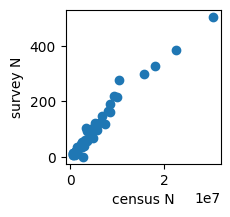

In [14]:
# correlation plot
fig,ax = plt.subplots(1,1, figsize=(2,2))
ax.scatter(state_pop_df['census N'], state_pop_df['survey N'])
ax.set_xlabel('census N')
ax.set_ylabel('survey N')

In [15]:
# set up table with N and %
state_pop_df['census %'] = state_pop_df['census proportion'].apply(lambda p: '%0.1f%%'%(100*p))
state_pop_df['survey %'] = state_pop_df['survey proportion'].apply(lambda p: '%0.1f%%'%(100*p))
state_pop_df[['survey N', 'survey %', 'census N', 'census %']]

survey N survey %  census N census %
state                                                     
Alabama                   67.0     1.3%   3962734     1.5%
Alaska                    10.0     0.2%    557060     0.2%
Arizona                   95.0     1.9%   5770187     2.2%
Arkansas                  46.0     0.9%   2348518     0.9%
California               505.0    10.0%  30523315    11.6%
Colorado                  91.0     1.8%   4624351     1.8%
Connecticut               39.0     0.8%   2895175     1.1%
Delaware                  13.0     0.3%    810269     0.3%
District of Columbia      14.0     0.3%    547328     0.2%
Florida                  327.0     6.5%  17948469     6.8%
Georgia                  161.0     3.2%   8402753     3.2%
Hawaii                    21.0     0.4%   1142870     0.4%
Idaho                     18.0     0.4%   1475629     0.6%
Illinois                 216.0     4.3%   9861901     3.7%
Indiana                  121.0     2.4%   5263114     2.0%
Iowa                      46.0     0.9%   2476028     0.9%
Kansas                    39.0     0.8%   2246318     0.9%
Kentucky                  91.0     1.8%   3507735     1.3%
Louisiana                 56.0     1.1%   3528548     1.3%
Maine                     19.0     0.4%   1137442     0.4%
Maryland                 103.0     2.0%   4818071     1.8%
Massachusetts            117.0     2.3%   5644540     2.1%
Michigan                 164.0     3.3%   7924418     3.0%
Minnesota                 97.0     1.9%   4423022     1.7%
Mississippi               35.0     0.7%   2261996     0.9%
Missouri                  67.0     1.3%   4813049     1.8%
Montana                    8.0     0.2%    889114     0.3%
Nebraska                  34.0     0.7%   1491246     0.6%
Nevada                    54.0     1.1%   2487994     0.9%
New Hampshire             21.0     0.4%   1142307     0.4%
New Jersey               117.0     2.3%   7267590     2.8%
New Mexico                27.0     0.5%   1653831     0.6%
New York                 300.0     6.0%  15687863     6.0%
North Carolina           189.0     3.8%   8404094     3.2%
North Dakota               5.0     0.1%    596486     0.2%
Ohio                     219.0     4.4%   9193508     3.5%
Oklahoma                  60.0     1.2%   3066654     1.2%
Oregon                   103.0     2.0%   3403149     1.3%
Pennsylvania             275.0     5.5%  10347543     3.9%
Rhode Island              18.0     0.4%    889822     0.3%
South Carolina            69.0     1.4%   4164762     1.6%
South Dakota              11.0     0.2%    690659     0.3%
Tennessee                105.0     2.1%   5513202     2.1%
Texas                    384.0     7.6%  22573234     8.6%
Utah                      36.0     0.7%   2449192     0.9%
Vermont                   12.0     0.2%    532307     0.2%
Virginia                 148.0     2.9%   6816709     2.6%
Washington               123.0     2.4%   6139213     2.3%
West Virginia             23.0     0.5%   1423234     0.5%
Wisconsin                100.0     2.0%   4646910     1.8%
Wyoming                    6.0     0.1%    451267     0.2%
Puerto Rico                0.0     0.0%   2703450     1.0%

### Compare gender


Census data for 18+ population:
```
Male: 49.00%
Female: 51.00%
```

From DP05: ACS DEMOGRAPHIC AND HOUSING ESTIMATES (2021) 5-Year estimates.

Notes:
- Our survey did not limit to a male/female binary.
- When we do limit to the male/female binary, our survey data proportions match census estimates!

How do you describe yourself?


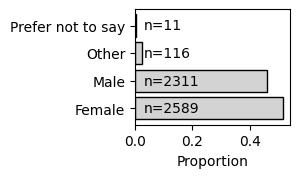

survey N survey %
Q-demos-gender                      
Female                 2589    51.5%
Male                   2311    46.0%
Other                   116     2.3%
Prefer not to say        11     0.2%

In [16]:
print(fields_df.loc['Q-demos-gender'][0])
gender_df = survey_df['Q-demos-gender'].value_counts().rename('survey N').to_frame()
fig, ax = plt.subplots(figsize=(2,1.5), dpi=100)
gender_df = plot_survey_proportion_with_N(gender_df, ax)
plt.show()
gender_df[['survey N', 'survey %']]

## Compare age groups

Census data:

> Annual Estimates of the Resident Population by Single Year of Age and Sex for the United States: April 1, 2020 to July 1, 2022 (NC-EST2022-AGESEX-RES)


About the data:
https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/NC-EST2022-AGESEX-RES.pdf

The key for SEX is as follows:
- 0 = Total
- 1 = Male
- 2 = Female

AGE is single-year of age (0, 1, 2, . . ., 99, 100+ years) and 999 is used to indicate total population.
(i.e. AGE=100 includes 100+)

We use totals, aggregating over age, limiting to 18+


In [17]:
census_age_df = pd.read_csv(census_data_dir + 'age-by-sex-2022-est.csv')
# Can drop total because we recalculate total without < 18
census_age_df = census_age_df[(census_age_df['SEX']==0) & (census_age_df['AGE']<= 100)].rename(
    columns={'POPESTIMATE2022': 'N'}
).drop('SEX', axis=1)
# First calculate the number of people less than 18
print('census N=%s with age < 18; we drop them' % census_age_df[census_age_df['AGE']<18]['N'].sum())
census_age_df = census_age_df[(census_age_df['AGE']>= 18)]
census_age_df

census N=72450827 with age < 18; we drop them


AGE        N
18    18  4326642
19    19  4295710
20    20  4438006
21    21  4723644
22    22  4663473
..   ...      ...
96    96   145421
97    97   109622
98    98    78028
99    99    53870
100  100    88988

[83 rows x 2 columns]

In [18]:
print('Our survey data:')
age_df = survey_df['q-demos-age'].value_counts().sort_index().rename('survey N').to_frame()
age_df

Our survey data:


survey N
q-demos-age            
18 - 24 years       768
25 - 34 years      1813
35 - 44 years      1240
45 - 54 years       677
55 - 64 years       374
65 and older        155

Pearson correlation (r, pvalue): (-0.223, 0.671)


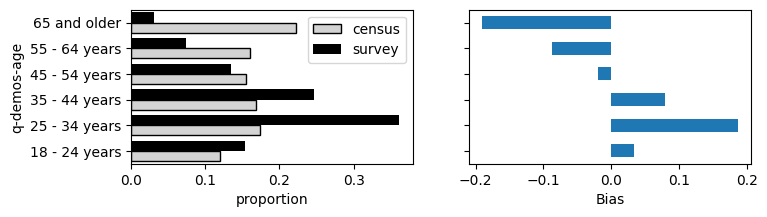

survey N survey % census %
q-demos-age                              
18 - 24 years       768    15.3%    12.0%
25 - 34 years      1813    36.1%    17.4%
35 - 44 years      1240    24.7%    16.8%
45 - 54 years       677    13.5%    15.5%
55 - 64 years       374     7.4%    16.1%
65 and older        155     3.1%    22.2%

In [19]:
# Aggregate census data to age groups matching survey data
age_df['census N'] = [
    census_age_df[census_age_df['AGE'].isin(range(18,25))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(25,35))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(35,45))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(45,55))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(55,65))]['N'].sum(),
    census_age_df[census_age_df['AGE'] >= 65]['N'].sum(),
]
age_df = set_proportions_and_bias(age_df)
# Calculate Pearson correlation
(r, pvalue) = pearsonr(age_df['census proportion'], age_df['survey proportion'])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True)
plot_census_vs_survey_pops(age_df, ax=ax1)
plot_bias(age_df, ax=ax2)
plt.show()
age_df[['survey N', 'survey %', 'census %']]

Notes:
- Our data is highly biased w.r.t. age. 
- Overall sample under represents people older than 45, over represents younger than 45
- Sample greatly under represents people older than 55
- Sample greatly over represents people 25-34

### Household income distribution

We use:
HINC-01. Selected Characteristics of Households by Total Money Income in 2021

Source: 
> U.S. Census Bureau, Current Population Survey, 2022 Annual Social and Economic Supplement (CPS ASEC).	

At time of analysis, 2022 estimates not available.
2022 survey data were used to produce estimates for 2021.

Census data are reported in the 1000's

Our survey data:
What was your total household income before taxes during the past 12 months?


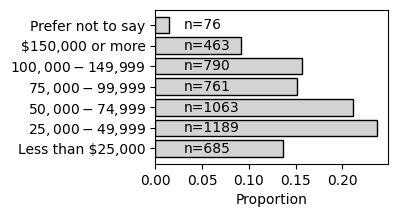

survey N  survey proportion survey %
Q-demos-income                                           
Less than $25,000         685           0.136264    13.6%
$25,000 - $49,999        1189           0.236523    23.7%
$50,000 - $74,999        1063           0.211458    21.1%
$75,000 - $99,999         761           0.151383    15.1%
$100,000 - $149,999       790           0.157151    15.7%
$150,000 or more          463           0.092103     9.2%
Prefer not to say          76           0.015118     1.5%

In [20]:
print('Our survey data:')
Q = 'Q-demos-income'
print(fields_df.loc[Q][0])
income_groups = [
    'Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999','$75,000 - $99,999',
    '$100,000 - $149,999', '$150,000 or more', 'Prefer not to say'
]
income_df = survey_df[Q].value_counts().rename('survey N').to_frame().reindex(income_groups)
income_df['survey proportion'] = income_df['survey N']/income_df['survey N'].sum()
fig, ax = plt.subplots(figsize=(3,2), dpi=100)
plot_survey_proportion_with_N(income_df, ax)
plt.show()
income_df

Pearson correlation (r, pvalue): (0.103, 0.845)


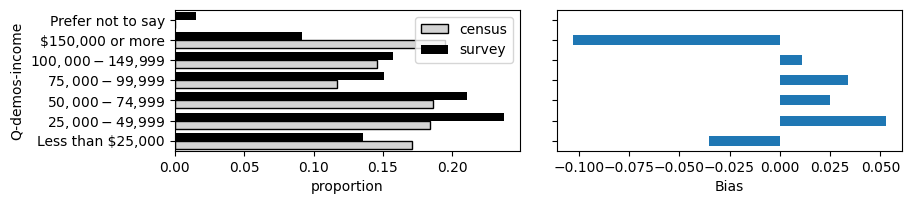

survey N survey % census %
Q-demos-income                                 
Less than $25,000         685    13.6%    17.1%
$25,000 - $49,999        1189    23.7%    18.4%
$50,000 - $74,999        1063    21.1%    18.6%
$75,000 - $99,999         761    15.1%    11.7%
$100,000 - $149,999       790    15.7%    14.6%
$150,000 or more          463     9.2%    19.5%
Prefer not to say          76     1.5%     nan%

In [21]:
# census data
census_income_df = pd.read_csv(census_data_dir + 'hinc01-totals.csv', thousands=',').transpose()
census_income_df.columns = ['N']
income_df['census N'] = [
    census_income_df.loc[[
        'Under $5,000', '$5,000 to $9,999', '$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$25,000 to $29,999', '$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $44,999', '$45,000 to $49,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$50,000 to $54,999', '$55,000 to $59,999', '$60,000 to $64,999', '$65,000 to $69,999', '$70,000 to $74,999','$75,000 to $79,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$75,000 to $79,999', '$80,000 to $84,999', '$85,000 to $89,999','$90,000 to $94,999', '$95,000 to $99,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$100,000 to $104,999','$105,000 to $109,999', '$110,000 to $114,999', 
        '$115,000 to $119,999','$120,000 to $124,999', '$125,000 to $129,999', 
        '$130,000 to $134,999','$135,000 to $139,999', '$140,000 to $144,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$150,000 to $154,999', '$155,000 to $159,999', '$160,000 to $164,999',
        '$165,000 to $169,999', '$170,000 to $174,999', '$175,000 to $179,999',
        '$180,000 to $184,999', '$185,000 to $189,999', '$190,000 to $194,999',
        '$195,000 to $199,999', '$200,000 and over'
    ]]['N'].sum(),
    np.nan,
]
income_df = set_proportions_and_bias(income_df)
# Calculate Pearson correlation -- drop 'Prefer not to say'
(r, pvalue) = pearsonr(income_df.drop('Prefer not to say')['census proportion'],
                       income_df.drop('Prefer not to say')['survey proportion'])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True)
plt.tight_layout()
plot_census_vs_survey_pops(income_df, ax=ax1)
plot_bias(income_df, ax=ax2)
plt.show()
income_df[['survey N', 'survey %', 'census %']]

Notes:

- Survey data is very biased w.r.t. household income distribution
- survey sample greatly under represents households making > \$150k
- survey sample also under represents households making < \$25k

### Education

Educational Attainment in the United States: 2022

Source: 
> U.S. Census Bureau, Current Population Survey, 2022 Annual Social and Economic Supplement (CPS ASEC).

Census data are again in the 1,000's.

Our survey data:
What is the highest level of education you have completed?


survey N  survey proportion survey %
Q-demos-education                                                    
Some high school or less               46           0.009151     0.9%
High school diploma or GED           1860           0.370002    37.0%
Bachelor's degree                    2219           0.441416    44.1%
Graduate or professional degree       870           0.173065    17.3%
Prefer not to say                      32           0.006366     0.6%

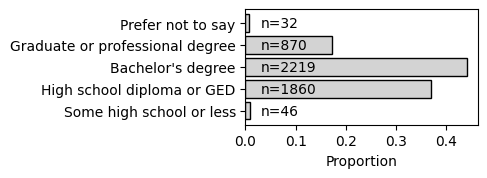

In [22]:
print('Our survey data:')
Q = 'Q-demos-education'
print(fields_df.loc[Q][0])
edu_groups = [
    'Some high school or less', 'High school diploma or GED', 'Bachelor\'s degree',
    'Graduate or professional degree', 'Prefer not to say'
]
edu_df = (survey_df[Q].value_counts().rename('survey N').to_frame()
          # rename this very long index value
          .rename(index={'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS, etc)': 'Graduate or professional degree'})
          .reindex(edu_groups))
edu_df['survey proportion'] = edu_df['survey N']/edu_df['survey N'].sum()
fig, ax = plt.subplots(figsize=(3,1.5), dpi=100)
plot_survey_proportion_with_N(edu_df, ax)
# plt.show()
edu_df

Pearson correlation (r, pvalue): (0.628, 0.372)


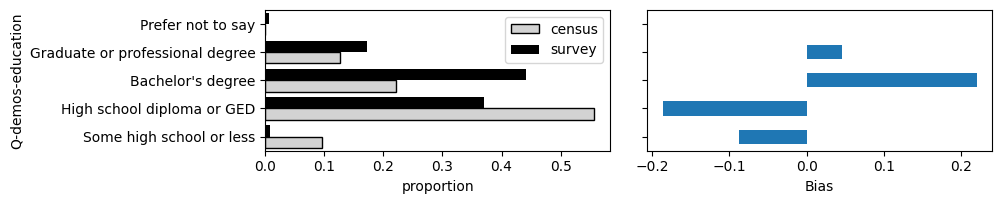

survey N survey % census %
Q-demos-education                                          
Some high school or less               46     0.9%     9.6%
High school diploma or GED           1860    37.0%    55.6%
Bachelor's degree                    2219    44.1%    22.1%
Graduate or professional degree       870    17.3%    12.7%
Prefer not to say                      32     0.6%     nan%

In [23]:
census_edu_df = pd.read_csv(census_data_dir + 'education-attainment-2022.csv', thousands=',').transpose()
census_edu_df.columns = ['N']
edu_df['census N'] = [
    census_edu_df.loc[[
        'None', '1st - 4th grade', '5th - 6th grade', '7th - 8th grade', '9th grade', '10th grade', '11th grade2',
    ]]['N'].sum(),
    census_edu_df.loc[[
        'High school graduate3', 'Some college, no degree', 'Associate\'s degree, occupational', 'Associate\'s degree, academic',
    ]]['N'].sum(),
    census_edu_df.loc[[
        'Bachelor\'s degree',
    ]]['N'].sum(),
    census_edu_df.loc[[
        'Master\'s degree', 'Professional degree', 'Doctoral degree'
    ]]['N'].sum(),
    np.nan
]
edu_df = set_proportions_and_bias(edu_df)
# Calculate Pearson correlation
(r, pvalue) = pearsonr(edu_df['census proportion'].drop('Prefer not to say'),
                       edu_df['survey proportion'].drop('Prefer not to say'))
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True)
plt.tight_layout()
plot_census_vs_survey_pops(edu_df, ax=ax1)
plot_bias(edu_df, ax=ax2)
plt.show()
edu_df[['survey N', 'survey %', 'census %']]

Notes:
- The sample is highly biased w.r.t. educational attainment
- sample greatly over represents people with a bachelor's degree
- sample greatly under represents people with a highschool diploma or less

### Race and Spanish/Latino/Hispanic origin

Note that both the census and our survey ask separately for Spanish/Hispanic origin.

We use table NC-EST2021-SR11H.

Note race data slightly differs across sources offered by the census.

Suggested Citation:			
> Annual Estimates of the Resident Population by Sex, Race, and Hispanic Origin for the United States: April 1, 2020 to July 1, 2021 (NC-EST2021-SR11H)			

Source: U.S. Census Bureau, Population Division			
Release Date: June 2022	

Downloaded from:
https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html

Data available [here](https://docs.google.com/spreadsheets/d/1i3OAjXzCX8CnRfybB_WEuRIFKKMtEsMrFt2A_T0qFwY/edit#gid=1363938624).

---

From US census quick facts: 
https://www.census.gov/quickfacts/fact/table/US/RHI125221

- 75.8%: White alone
- 18.9% Hispanic or Latino

The census source notes: Hispanics may be of any race, so also are included in applicable race categories

--- 

#### Notes

- Our data is highly correlated with census data w.r.t. race (p<0.001)
- Black participants underrepresented


Are you of Spanish, Hispanic, or Latino origin?


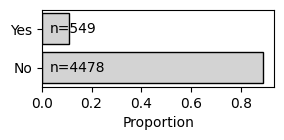

survey N survey %
Q-demos-hispanic                   
No                    4478    89.1%
Yes                    549    10.9%

In [24]:
Q = 'Q-demos-hispanic'
print(fields_df.loc[Q][0])
hisp_df = survey_df[Q].value_counts().rename('survey N').to_frame()
hisp_df['survey proportion'] = round(hisp_df['survey N']/hisp_df['survey N'].sum(), 3)
fig, ax = plt.subplots(figsize=(3,1), dpi=100)
plot_survey_proportion_with_N(hisp_df, ax)
plt.show()
hisp_df[['survey N', 'survey %']]

### Race

Note our survey allowed multiple choices to be selected.

Note census does not have a category for 'Other' which our survey did.
So we make a combined category for 'Other or mixed'.

In particular we map the census 'Two or More Races' category to 'Other or Mixed' and map anyone in our survey who selected 'Other' or more than 2 races to 'Other or Mixed'.


In [25]:
census_race_df = pd.read_csv(census_data_dir + 'race-2021-est.csv', thousands=',').set_index('race')
assert(
    census_race_df.loc['TOTAL POPULATION']['population'] == census_race_df.drop('TOTAL POPULATION').sum()['population'] 
)
# safe to drop total population give above assert
census_race_df.drop('TOTAL POPULATION', inplace=True)
census_race_df

population
race                                                  
White                                        251461611
Black or African American                     45060857
American Indian and Alaska Native              4367540
Asian                                         20350483
Native Hawaiian and Other Pacific Islander      863043
Two or More Races                              9790211

In [26]:
# First just show what the data looks like
Q = 'Q-demos-race'
print(fields_df.loc[Q][0])
race_df = survey_df[Q].value_counts().rename('survey N').to_frame()
race_df['survey proportion'] = round(race_df['survey N']/race_df['survey N'].sum(), 3)
race_df.head()

Choose one or more races that you consider yourself to be


survey N  survey proportion
Q-demos-race                                          
White or Caucasian             3886              0.773
Asian                           377              0.075
Black or African American       351              0.070
Other                           105              0.021
White or Caucasian,Asian         76              0.015

Pearson correlation (r, pvalue): (0.992, 0.000)


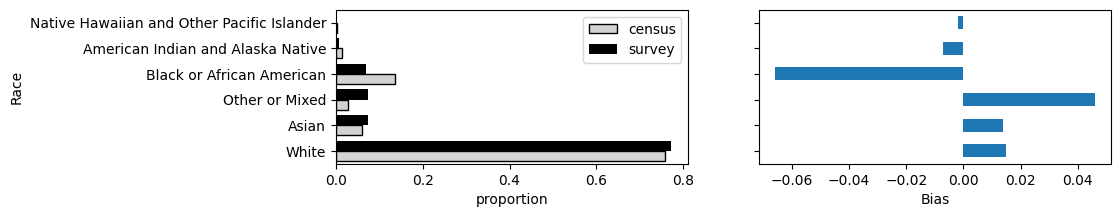

survey N survey % census %
Race                                                                  
White                                           3886    77.3%    75.8%
Asian                                            377     7.5%     6.1%
Other or Mixed                                   376     7.5%     2.9%
Black or African American                        351     7.0%    13.6%
American Indian and Alaska Native                 32     0.6%     1.3%
Native Hawaiian and Other Pacific Islander         5     0.1%     0.3%

In [27]:
# Map two or more races to 'Two or more races'
# And map the names to match the census data
race_df = (survey_df[Q].apply(lambda r: 'Other or Mixed' if ((len(r.split(',')) > 1) or r=='Other') else r)
           .value_counts().rename('survey N').to_frame()
           .rename({
               'White or Caucasian': 'White',
               'Native Hawaiian or Other Pacific Islander':'Native Hawaiian and Other Pacific Islander',
               'American Indian/Native American or Alaska Native': 'American Indian and Alaska Native',
           }))
race_df.index.rename('Race', inplace=True)

race_df['census N'] = race_df.index.map(census_race_df['population'].rename({
 'Two or More Races': 'Other or Mixed'   
}))
race_df = set_proportions_and_bias(race_df)
# Calculate Pearson correlation - Drop 'Other' for this calculation
(r, pvalue) = pearsonr(race_df['census proportion'], 
                       race_df['survey proportion'])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 2), sharey=True)
plot_census_vs_survey_pops(race_df, ax=ax1)
plot_bias(race_df, ax=ax2)
plt.show()
race_df[['survey N','survey %', 'census %']].sort_values('survey N', ascending=False)

### Sexual orientation

A quick look at the number of sample participants identifying as LGBTQ+

Which best describes your sexual orientation?


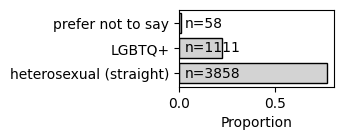

survey N survey %
Q-sexual-orientation                      
heterosexual (straight)      3858    76.7%
LGBTQ+                       1111    22.1%
prefer not to say              58     1.2%

In [28]:
Q = 'Q-sexual-orientation'
print(fields_df.loc[Q][0])
sexual_orientation_df = survey_df[Q].value_counts().rename('survey N').to_frame()
fig, ax = plt.subplots(figsize=(2,1), dpi=100)
plot_survey_proportion_with_N(sexual_orientation_df, ax)
plt.show()
sexual_orientation_df[['survey N', 'survey %']]

---

Next we look at consumer groups not related to the census.

### Purchase frequency


How often do you (+ anyone you share your account with) order deliveries from Amazon?


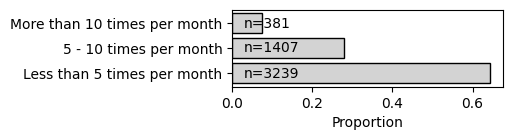

survey N survey %
Q-amazon-use-how-oft                           
Less than 5 times per month       3239    64.4%
5 - 10 times per month            1407    28.0%
More than 10 times per month       381     7.6%

In [29]:
Q = 'Q-amazon-use-how-oft'
print(fields_df.loc[Q][0])
freq_df = survey_df[Q].value_counts().rename('survey N').to_frame()
fig, ax = plt.subplots(figsize=(3.5,1), dpi=100)
freq_df = plot_survey_proportion_with_N(freq_df, ax)
plt.show()
freq_df[['survey N','survey %']]

### Number of people share Amazon account with

How many people do you share your Amazon account with? i.e. how many people log in and make orders using your account?


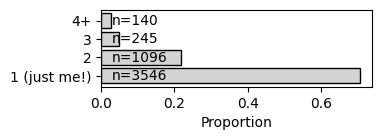

survey N survey %
Q-amazon-use-howmany                   
1 (just me!)              3546    70.5%
2                         1096    21.8%
3                          245     4.9%
4+                         140     2.8%

In [30]:
Q = 'Q-amazon-use-howmany'
print(fields_df.loc[Q][0])
freq_df = survey_df[Q].value_counts().rename('survey N').sort_index().to_frame()
fig, ax = plt.subplots(figsize=(3.5,1), dpi=100)
freq_df = plot_survey_proportion_with_N(freq_df, ax)
plt.show()
freq_df[['survey N','survey %']]

### Household size

How many people are in your "household"?


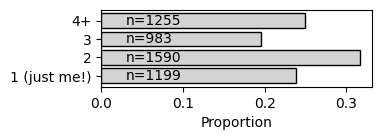

survey N survey %
Q-amazon-use-hh-size                   
1 (just me!)              1199    23.9%
2                         1590    31.6%
3                          983    19.6%
4+                        1255    25.0%

In [31]:
Q = 'Q-amazon-use-hh-size'
print(fields_df.loc[Q][0])
freq_df = survey_df[Q].value_counts().rename('survey N').sort_index().to_frame()
fig, ax = plt.subplots(figsize=(3.5,1), dpi=100)
freq_df = plot_survey_proportion_with_N(freq_df, ax)
plt.show()
freq_df[['survey N','survey %']]

In [32]:
Q = 'Q-life-changes'
print(fields_df.loc[Q][0])
life_changes = [
    'Lost a job',
    'Divorce',
    'Moved place of residence',
    'Became pregnant',
    'Had a child',
]
lc_N = []
for lc in life_changes:
    lc_N += [survey_df[Q].apply(lambda s: lc in [ss.strip() for ss in str(s).split(',')]).sum()]

life_changes_df = pd.DataFrame({
    #'Life changes in 2021': life_changes,
    'N': lc_N,
}, index=life_changes).sort_values('N', ascending=False)
life_changes_df['%'] = life_changes_df['N'].apply(lambda n: '%0.1f%%'%(100*n/len(survey_df)))
life_changes_df

In 2021 did you, or someone you share your Amazon account with, experience any of the following life changes?

Please mark all that apply.


N      %
Moved place of residence  1091  21.7%
Lost a job                 596  11.9%
Had a child                159   3.2%
Became pregnant            145   2.9%
Divorce                     64   1.3%

### Substance use and personal questions

In [33]:
N = len(survey_df)

In [34]:
substance_use_qs = ['Q-substance-use_1', 'Q-substance-use_2', 'Q-substance-use_3']
Q = substance_use_qs[0]
freq_df = round(survey_df[Q].value_counts().rename(Q).sort_index()*100/N,1).to_frame()
for Q in substance_use_qs:
    print('%s\n'%fields_df.loc[Q][0])
    freq_df[Q] = (survey_df[Q].value_counts().rename(Q).sort_index()/N).apply(lambda p: '%0.1f%%'%(100*p))
    #proportion

freq_df.transpose()[['Yes','No', 'Prefer not to say', 'I stopped in the recent past']]

Are any of the following the case for:

You or someone in your household or someone you share your Amazon account with? - Smoke cigarettes regularly?

Are any of the following the case for:

You or someone in your household or someone you share your Amazon account with? - Smoke marijuana regularly?

Are any of the following the case for:

You or someone in your household or someone you share your Amazon account with? - Drink alcohol regularly?



Q-substance-use_1    Yes     No Prefer not to say I stopped in the recent past
Q-substance-use_1  15.0%  81.5%              0.2%                         3.2%
Q-substance-use_2  21.1%  75.2%              0.9%                         2.7%
Q-substance-use_3  44.0%  52.5%              0.5%                         3.1%

In [35]:
personal_qs = ['Q-personal_1', 'Q-personal_2']
Q = personal_qs[0]
freq_df = round(survey_df[Q].value_counts().rename(Q).sort_index()*100/N,1).to_frame()
for Q in personal_qs:
    print('%s\n'%fields_df.loc[Q][0])
    freq_df[Q] = (survey_df[Q].value_counts().rename(Q).sort_index()/N).apply(lambda p: '%0.1f%%'%(100*p))
freq_df.transpose()[['Yes','No', 'Prefer not to say']]

Are any of the following the case for:

You or someone in your household or someone you share your Amazon account with? - Have diabetes?

Are any of the following the case for:

You or someone in your household or someone you share your Amazon account with? - Use a wheelchair?



Q-personal_1    Yes     No Prefer not to say
Q-personal_1  12.3%  87.4%              0.3%
Q-personal_2   1.9%  97.8%              0.2%

## Other helper functions

### Plotting

In [36]:
def plot_monthly_data(series, ax=None, xmin='2018-01', xmax=MAX_YYYY_MM, ylabel=None,
                      label=None, title=None, show_covid=False, color=None, linestyle=None, legend=True):
    if ax is None:
        _fig, ax = plt.subplots(1,1, figsize=(14,2))
    ax.plot(series, label=label, color=color, linestyle=(linestyle or '-'))
    ax.set_xlim(xmin, xmax)
    if show_covid: ax.axvline(x='2020-03', ymin=0, color='gray', linestyle=':')
    if title: ax.set_title(title)
    if ylabel: ax.set_ylabel(ylabel)
    if label and legend: ax.legend()
    _ = plt.xticks(rotation=90)
    return ax

# Amazon data validation analysis

## Gift cards

There are a lot of gift cards. Identify the gift cards to be able to exclude them from some analysis as well as analyze them separately.

#### Add boolean identifier for gift cards

identify by 
- category GIFT_CARD
- title indicating gift card/code: amazon reload, gift code, etc

(Not all gift cards/codes have category GIFT_CARD)


#### Analyze gift card uses

Plot over time (yyyy-mm):
- total spend
- total purchases
- distinct purchasers


#### Notes

- There is a $2000 gift card.
- Overall likely some odd use of gift cards among some survey participants

In [37]:
def is_gift_code(row):
    cat = str(row['Category'])
    if cat in ['GIFT_CARD']:
        return True
    title = str(row['Title']).lower()
    if ('gift code' in title) or ('gift card' in title) or ('digital code' in title):
        return True
    if ('amazon reload' in title):
        return True
    return False

amzn_data[IS_GIFT_CARD] = amzn_data.apply(is_gift_code, axis=1)
gc_data = amzn_data[amzn_data[IS_GIFT_CARD]]
print('%s gift card purchases from %s users' % 
      (len(gc_data), gc_data[RESPONSE_ID].nunique()))
gc_data.head()

43060 gift card purchases from 3220 users


Order Date  Purchase Price Per Unit  Quantity Shipping Address State   
32 2019-10-05                     25.0       1.0                    NaN  \
33 2019-10-06                     50.0       1.0                    NaN   
34 2019-10-06                     50.0       1.0                    NaN   
67 2020-03-03                     10.0       1.0                    NaN   
72 2020-04-27                     25.0       1.0                    NaN   

                                              Title ASIN/ISBN (Product Code)   
32             Best Buy Gift Cards - Email Delivery               B07RTN4C77  \
33             Best Buy Gift Cards - Email Delivery               B07RTN4C77   
34             Best Buy Gift Cards - Email Delivery               B07RTN4C77   
67  $10 -PlayStation Store Gift Card [Digital Code]               B00GAC1D2G   
72             Best Buy Gift Cards - Email Delivery               B07RTN4C77   

            Category  Survey ResponseID  year  yyyy-mm  month   year-Q  spend   
32         GIFT_CARD  R_01vNIayewjIIKMF  2019  2019-10     10  2019-Q4   25.0  \
33         GIFT_CARD  R_01vNIayewjIIKMF  2019  2019-10     10  2019-Q4   50.0   
34         GIFT_CARD  R_01vNIayewjIIKMF  2019  2019-10     10  2019-Q4   50.0   
67  SCREEN_PROTECTOR  R_01vNIayewjIIKMF  2020  2020-03      3  2020-Q1   10.0   
72         GIFT_CARD  R_01vNIayewjIIKMF  2020  2020-04      4  2020-Q2   25.0   

    gift card  
32       True  
33       True  
34       True  
67       True  
72       True

### Descriptive statistics for gift cards

- unit prices
- number of purchases per respondent
- spend per respondent

In [38]:
print('unit prices')
display(gc_data[UNIT_PRICE].describe().apply("{0:.2f}".format).to_frame())
# fig, ax = plt.subplots(1,1, figsize=(6,2))
# _ = gc_data[UNIT_PRICE].hist(bins=100, ax=ax)
# _ = ax.set_title('gift card purchase prices')

unit prices


Purchase Price Per Unit
count                43060.00
mean                    29.82
std                     44.49
min                      0.50
25%                      5.00
50%                     20.00
75%                     40.00
max                   2000.00

In [39]:
print('gift card purchases per response id')
print('there are a few respondents making A LOT of gift card purchases')
gc_rids_purchases = gc_data.groupby(RESPONSE_ID)[DATE].count()
display(gc_rids_purchases.describe(
    [0.25,0.5, 0.75,0.9,0.95,0.99]
).apply("{0:.2f}".format).rename('gift card purchases').to_frame())
# get respondents making above the 99 percentile of purchases
gc_99_pct = round(np.percentile(gc_rids_purchases, 99))
print('%s = 99th percentile number of gift card purchases per response id' % gc_99_pct)
gc_99_pct_rids = gc_rids_purchases[
    gc_rids_purchases > gc_99_pct
].index
print('n=%s respondents with > %s gift card purchases' % (len(gc_99_pct_rids), gc_99_pct))

gift card purchases per response id
there are a few respondents making A LOT of gift card purchases


gift card purchases
count             3220.00
mean                13.37
std                 42.27
min                  1.00
25%                  2.00
50%                  4.00
75%                 11.00
90%                 26.00
95%                 48.00
99%                167.43
max               1122.00

167 = 99th percentile number of gift card purchases per response id
n=33 respondents with > 167 gift card purchases


In [40]:
print('per respondent gift card spend')
display(gc_data.groupby(RESPONSE_ID)[TOTAL_SPEND].sum().describe(
    [0.25,0.5, 0.75, 0.9, 0.95, 0.99]
).rename('spend').apply("{0:.2f}".format).to_frame())

per respondent gift card spend


spend
count   3220.00
mean     428.61
std     1032.45
min        0.50
25%       51.66
50%      150.00
75%      399.42
90%      972.35
95%     1630.89
99%     4468.49
max    31795.17

Plot over time (yyyy-mm):
- total spend
- total purchases
- unique users making purchases (unique response ids)

Also calculate metrics without the top 99th percentile of gift card purchasers

Limited to max date 2022-10

In [41]:
monthly_gc_purchases = gc_data.groupby(YYYY_MM)[TOTAL_SPEND].agg(
    ['sum','count']
).rename(columns={'sum':'total spend','count':'purchases'})
monthly_gc_purchases['unique users'] = gc_data.groupby(YYYY_MM)[RESPONSE_ID].nunique()
monthly_gc_purchases = monthly_gc_purchases.loc[:MAX_YYYY_MM] # limit to max date
print('including all response ids:')
display(monthly_gc_purchases.head())
# calculate the same metrics with only top 99th percentile of gift card purchasers
gc_data_99th_pct_rids = gc_data[gc_data[RESPONSE_ID].isin(gc_99_pct_rids)]
monthly_gc_purchases_99_pct = gc_data_99th_pct_rids.groupby(YYYY_MM)[TOTAL_SPEND].agg(
    ['sum','count']
).rename(columns={'sum':'total spend','count':'purchases'})
monthly_gc_purchases_99_pct['unique users'] = gc_data_99th_pct_rids.groupby(YYYY_MM)[RESPONSE_ID].nunique()
monthly_gc_purchases_99_pct = monthly_gc_purchases_99_pct.loc[:MAX_YYYY_MM] # limit to max date
print('only top 99th percentile of gift card purchasers:')
display(monthly_gc_purchases_99_pct.head())
# calculate the same metrics without top 99th percentile of gift card purchasers
gc_data_less_99th_pct_rids = gc_data[~gc_data[RESPONSE_ID].isin(gc_99_pct_rids)]
monthly_gc_purchases_less_99_pct = gc_data_less_99th_pct_rids.groupby(YYYY_MM)[TOTAL_SPEND].agg(
    ['sum','count']
).rename(columns={'sum':'total spend','count':'purchases'})
monthly_gc_purchases_less_99_pct['unique users'] = gc_data_less_99th_pct_rids.groupby(YYYY_MM)[RESPONSE_ID].nunique()
monthly_gc_purchases_less_99_pct = monthly_gc_purchases_less_99_pct.loc[:MAX_YYYY_MM] # limit to max date

including all response ids:


total spend  purchases  unique users
yyyy-mm                                      
2018-01     10087.14        395           189
2018-02     10684.60        348           168
2018-03     10272.47        390           199
2018-04     10082.91        367           178
2018-05     10537.71        355           187

only top 99th percentile of gift card purchasers:


total spend  purchases  unique users
yyyy-mm                                      
2018-01       858.83         95            11
2018-02      1323.53        125            16
2018-03      1108.17        100            13
2018-04      1261.45        122            13
2018-05      1054.93        113            15

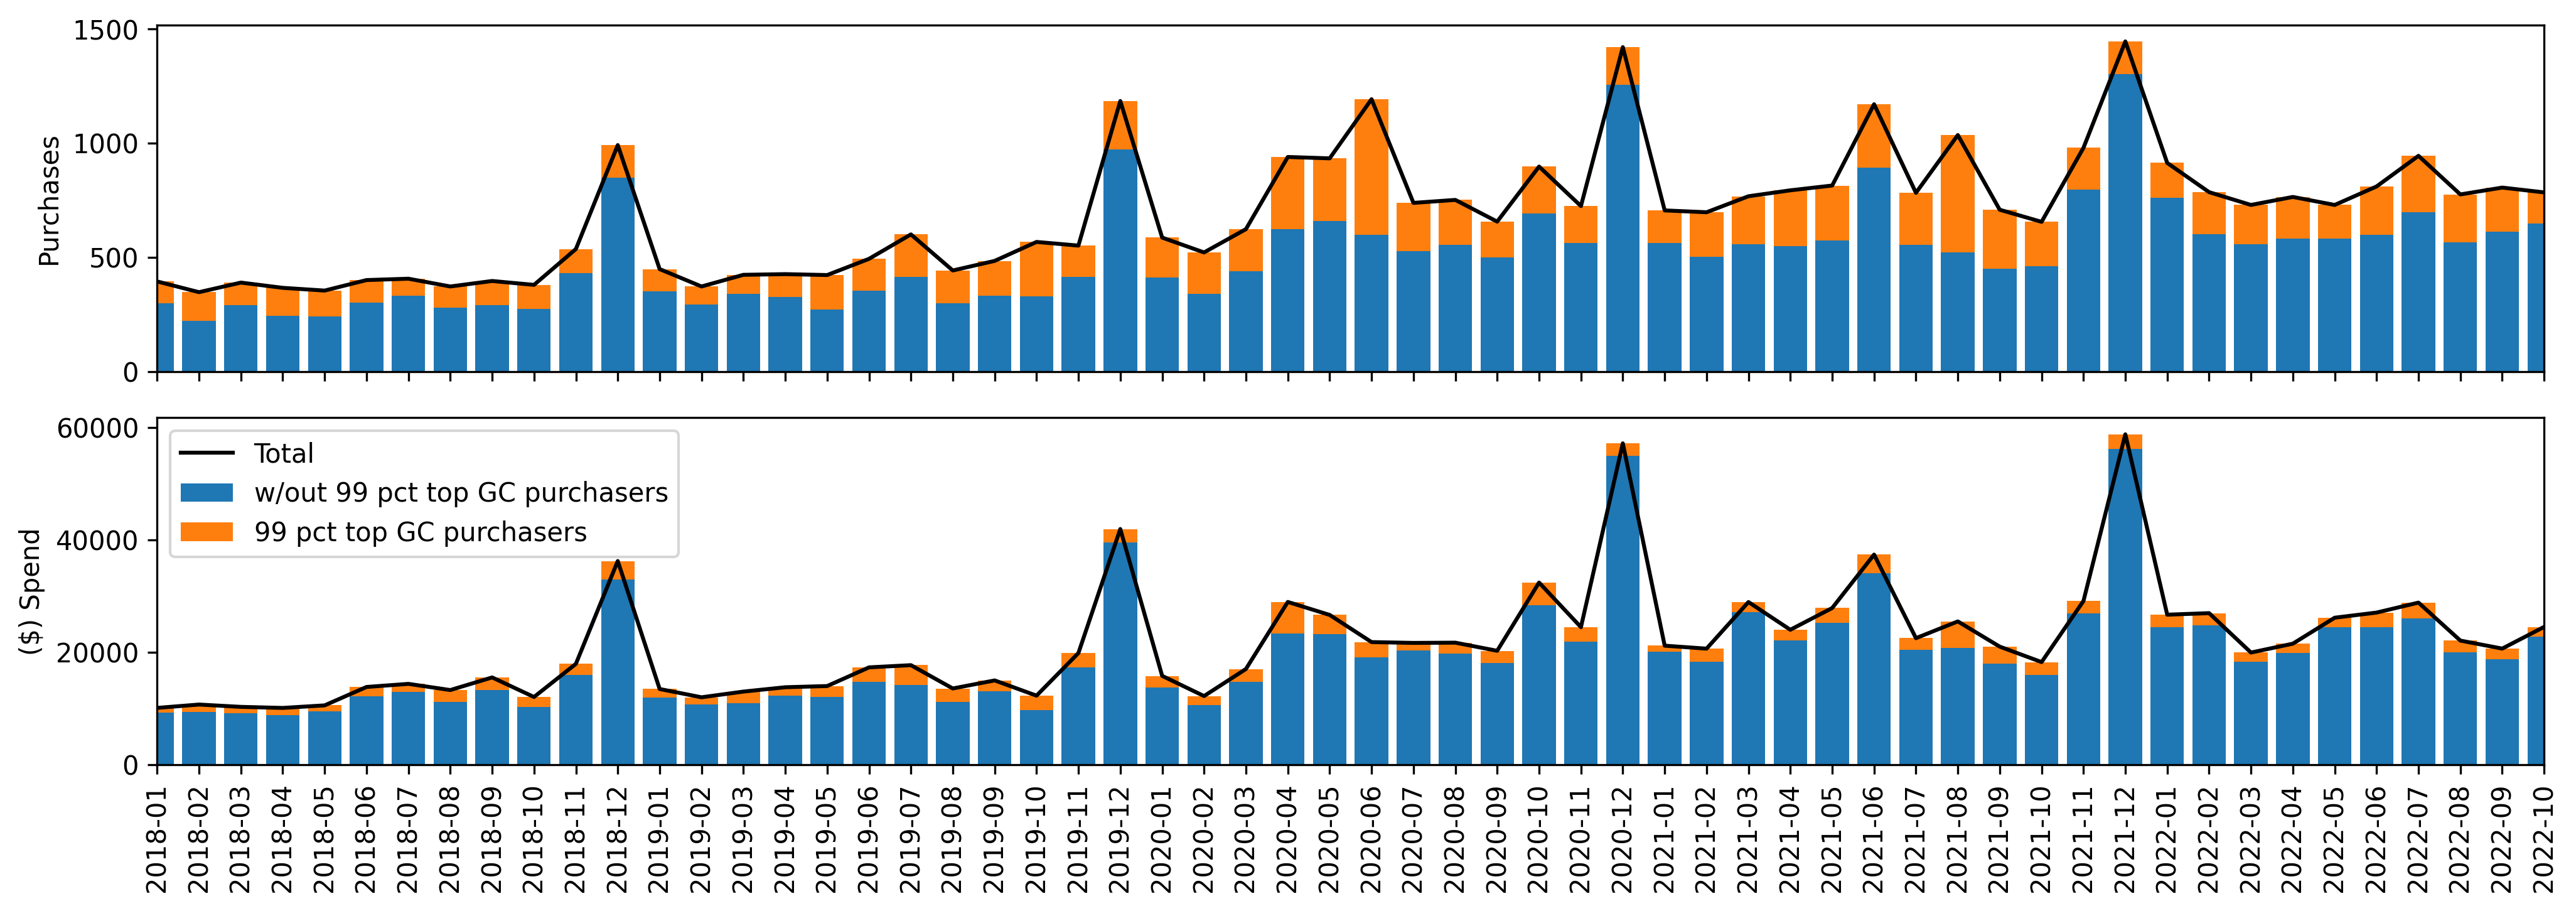

In [42]:
fig, axes = plt.subplots(2,1, figsize=(14,4.5), sharex=True, dpi=300)
ax = axes[0]
#ax.set_title('Monthly Gift Card Purchases')
ax.bar(plot_idx, monthly_gc_purchases_less_99_pct['purchases'], label='w/out 99 pct top GC purchasers')
ax.bar(plot_idx, monthly_gc_purchases_99_pct['purchases'], 
       bottom=monthly_gc_purchases_less_99_pct['purchases'], 
       label='99 pct top GC purchasers')
ax.plot(monthly_gc_purchases['purchases'], color='black', label='total purchases')
ax.set_ylabel('Purchases')
# do the same for spend
ax = axes[1]
ax.bar(plot_idx, monthly_gc_purchases_less_99_pct['total spend'], label='w/out 99 pct top GC purchasers')
ax.bar(plot_idx, monthly_gc_purchases_99_pct['total spend'], 
       bottom=monthly_gc_purchases_less_99_pct['total spend'], 
       label='99 pct top GC purchasers')
ax.plot(monthly_gc_purchases['total spend'], color='black', label='Total')
ax.set_ylabel('($) Spend')
ax.set_xlim('2018-01', MAX_YYYY_MM)
ax.legend(loc='upper left')
plt.tight_layout()
_ = plt.xticks(rotation=90)

The top 99th percentile of gift card (GC) purchasers greatly add to the number of total purchases.
Importantly, their data disturbs patterns in the number of gift card purchases (top).
However the top 99th percentile of GC purchasers do not greatly impact patterns in total spend (bottom).

And they do not greatly impact the number of unique respondents making purchases each month (below).

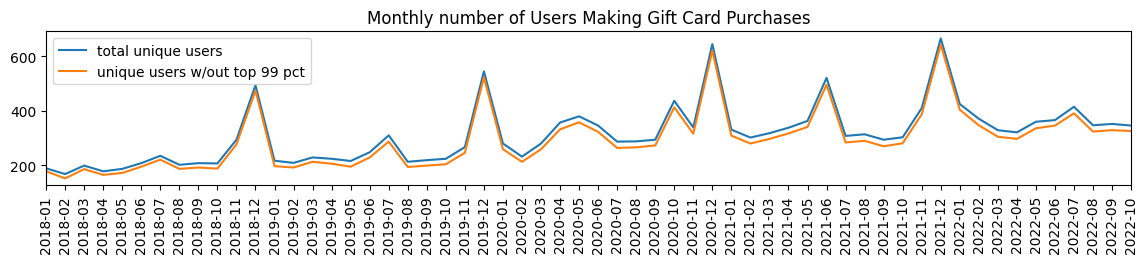

In [43]:
ax = plot_monthly_data(monthly_gc_purchases['unique users'], label='total unique users', 
                       title='Monthly number of Users Making Gift Card Purchases')
_ = plot_monthly_data(monthly_gc_purchases_less_99_pct['unique users'], 
                      label='unique users w/out top 99 pct', ax=ax)

Study gift card amount denominations (most popular).

There is an interesting number of 0.50 purchases (smallest amount possible).

Plot number of purchases by popular denominations over time.

In [44]:
# find most popular denominations
print('gift cards: most frequently purchased amounts')
gc_denominations = gc_data.groupby(UNIT_PRICE)[QUANTITY].sum().sort_values(ascending=False).to_frame()
display(gc_denominations.head(10))
gc_denominations_top = gc_denominations.head(8).index

gift cards: most frequently purchased amounts


Quantity
Purchase Price Per Unit          
25.0                       7391.0
50.0                       4815.0
0.5                        3902.0
10.0                       3332.0
100.0                      2186.0
5.0                        2127.0
20.0                       2037.0
1.0                        1609.0
30.0                       1066.0
40.0                        863.0

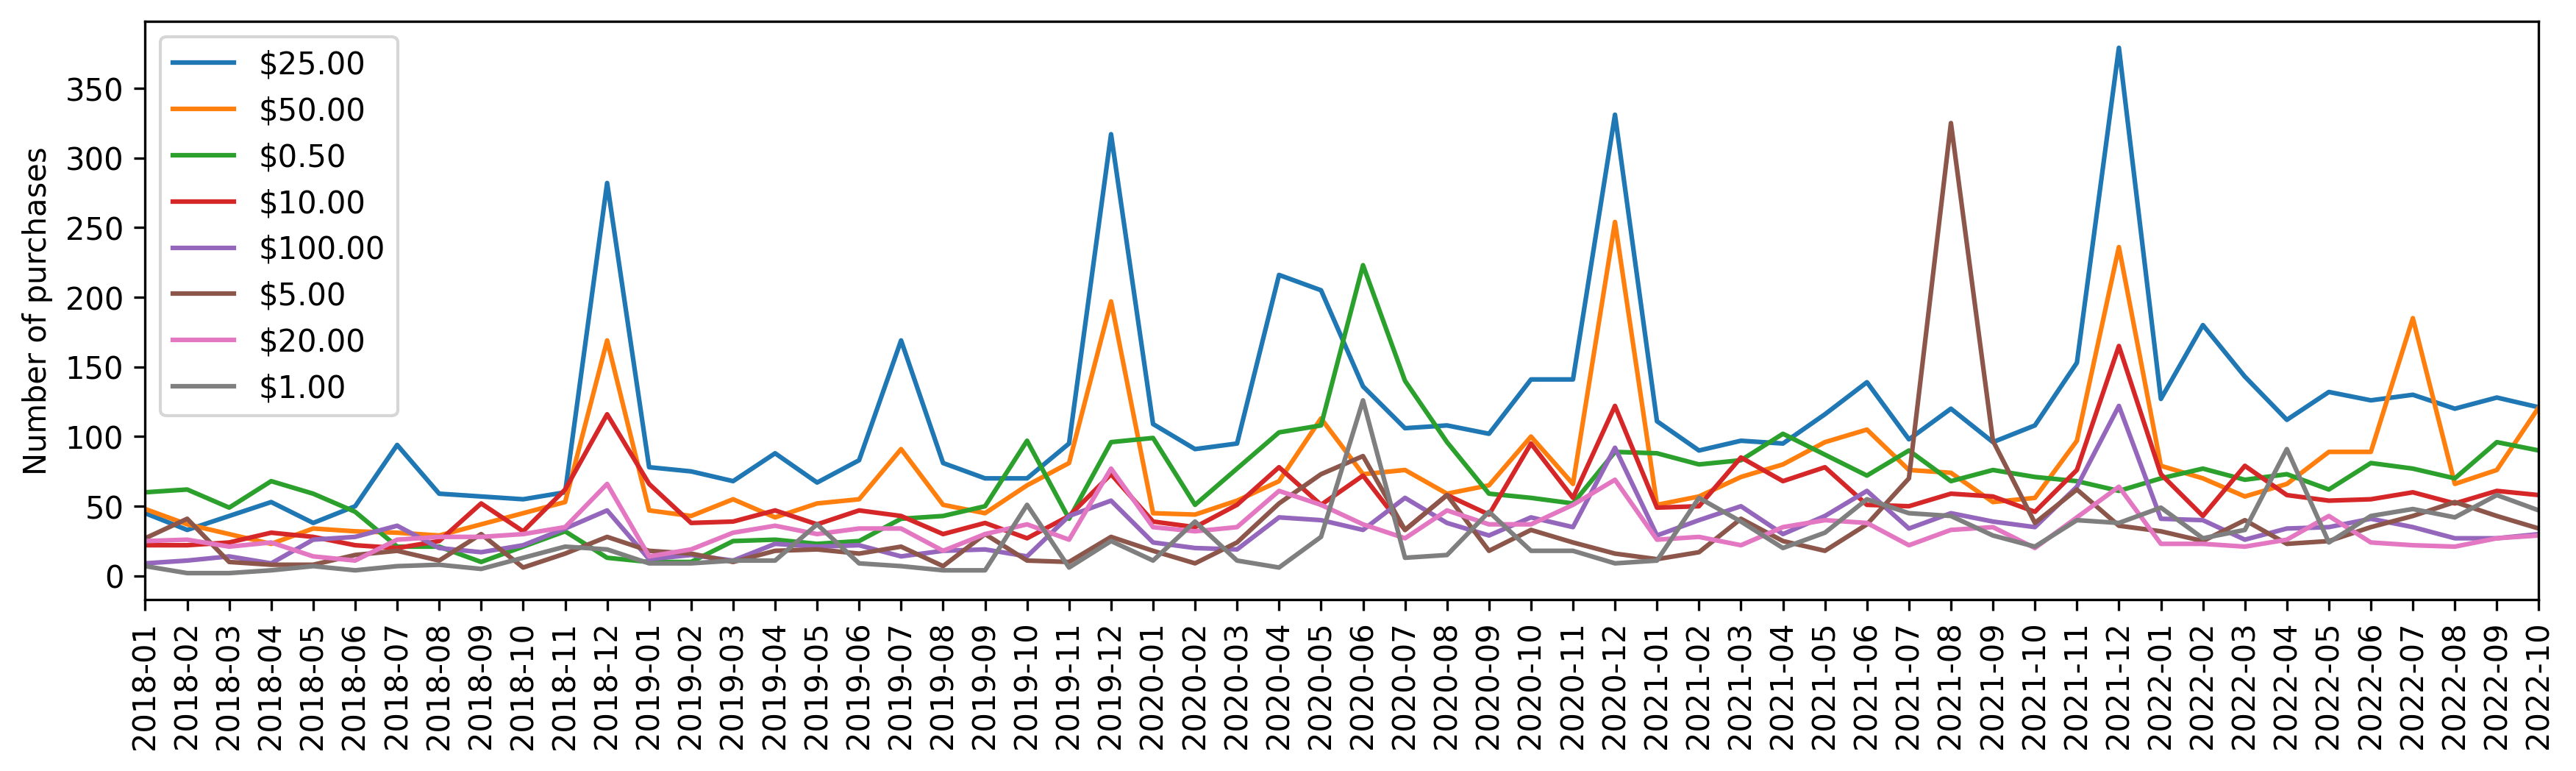

In [112]:
# collect monthly series of number of gc purchases
gc_purchases_by_denomination = {} # maps: denomination: time series
for denom in gc_denominations_top:
    gc_purchases_by_denomination[denom] = gc_data[gc_data[UNIT_PRICE]==denom].groupby(YYYY_MM)[QUANTITY].sum().loc[:MAX_YYYY_MM]

fig, ax = plt.subplots(1,1,figsize=(14,3.4), dpi=300)
#ax.set_title('Monthly Gift Card Purchases for Most Frequent Denominations')
for (denom, series) in gc_purchases_by_denomination.items():
    plot_monthly_data(series, label='$%0.2f'%denom, ax=ax)
_ = ax.set_ylabel('Number of purchases')

Simpler plot that still shows story of anomalies

Top 3 GC denominations purchases (includes $0.50) shown on left axis & total GC spend shown on right axis

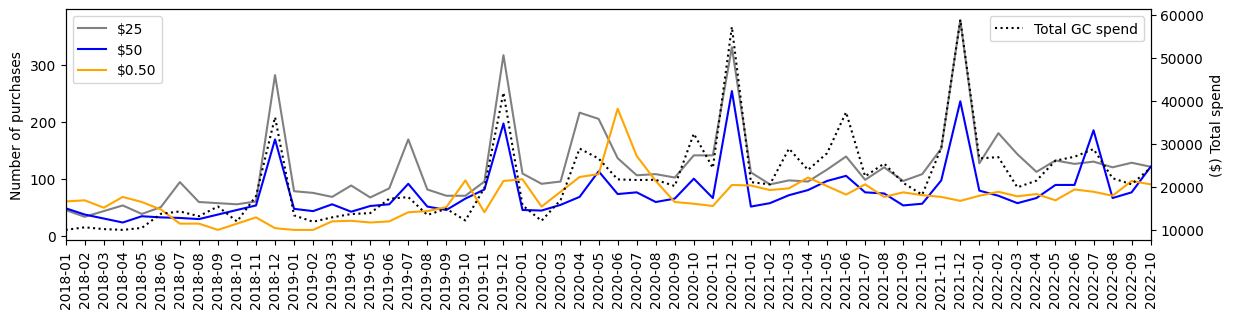

In [108]:
fig, ax = plt.subplots(1,1,figsize=(14,3))

plot_monthly_data(gc_purchases_by_denomination[25.0], label='$25', ax=ax, color='gray')
plot_monthly_data(gc_purchases_by_denomination[50.0], label='$50', ax=ax, color='blue')
plot_monthly_data(gc_purchases_by_denomination[0.5], label='$0.50', ax=ax, color='orange')
ax.set_ylabel('Number of purchases')   
ax.legend(loc='upper left')
ax2 = ax.twinx()

plot_monthly_data(monthly_gc_purchases['total spend'], ax=ax2, 
                  label='Total GC spend', color='black', linestyle=':')
ax2.set_ylabel('($) Total spend')
_ = ax2.legend(loc='upper right')
#_ = ax.set_title('Monthly Gift Card Purchases for Most Frequent Denominations')

## Basic descriptive statistics

- item unit prices
- number of purchases per respondent
- spend per respondent

In [47]:
print('item unit prices')
amzn_data[UNIT_PRICE].describe().apply("{0:.2f}".format).to_frame()

item unit prices


Purchase Price Per Unit
count              1850717.00
mean                    22.66
std                     46.00
min                      0.01
25%                      8.47
50%                     13.99
75%                     23.75
max                   6398.95

In [48]:
print('per respondent purchases')
amzn_data.groupby(RESPONSE_ID)[DATE].count().describe().apply("{0:.2f}".format).rename('purchases').to_frame()

per respondent purchases


purchases
count   5027.00
mean     368.16
std      426.41
min        1.00
25%       92.00
50%      232.00
75%      489.00
max     5415.00

In [49]:
print('per respondent spend')
amzn_data.groupby(RESPONSE_ID)[TOTAL_SPEND].sum().describe().rename('spend').apply("{0:.2f}".format).to_frame()

per respondent spend


spend
count    5027.00
mean     8763.40
std      9782.76
min         1.84
25%      2254.07
50%      5706.99
75%     11706.02
max    115391.18

### Top items and categories

Sorted by number of users.

In [50]:
# Top item categories, number of distinct users purchasing items in the category, 
# and total purchases, sorted by number of users. 
# Note there are product codes where the category changes over time in the longitudinal data.
top_cats = (
    amzn_data.groupby(CATEGORY)[RESPONSE_ID].agg(['nunique', 'count'])
    #.sort_values('count', ascending=False) # note if we sort by count then gift card in top 3
    .sort_values('nunique', ascending=False)
    .rename(columns={'nunique':'Users making purchases', 'count': 'Total purchases'})
)
top_cats['Total spend'] = amzn_data.groupby(CATEGORY)[TOTAL_SPEND].sum()
top_cats.head(10)

Users making purchases  Total purchases  Total spend
Category                                                                    
ABIS_BOOK                                 4236            87619   1359183.61
ELECTRONIC_CABLE                          3521            18268    222390.71
CELLULAR_PHONE_CASE                       3468            15370    229662.82
SHIRT                                     3365            27267    514584.54
HEADPHONES                                3307            11394    546323.79
HEALTH_PERSONAL_CARE                      3225            16625    312761.77
CHARGING_ADAPTER                          2872             8175    160851.17
NUTRITIONAL_SUPPLEMENT                    2782            26913    622680.77
SHOES                                     2781            12758    576419.42
PANTS                                     2755            15944    409062.39

In [51]:
# Top 5 item titles, number of distinct users purchasing the item, and total purchases, 
# sorted by number of purchasing users. 
# Note there are product codes with titles that change over time in the longitudinal data.
# Note that if we do not exclude GC's then they dominate top 5
top_titles_no_gc = (
    amzn_data[~amzn_data[IS_GIFT_CARD]].groupby(TITLE)[RESPONSE_ID].agg(['nunique', 'count'])
    .sort_values('nunique', ascending=False) 
    .rename(columns={'nunique':'Users making purchases', 'count': 'Total purchases'})
)
top_titles_no_gc['Total spend'] = amzn_data[~amzn_data[IS_GIFT_CARD]].groupby(TITLE)[TOTAL_SPEND].sum()
top_titles_no_gc.head(10)

Users making purchases   
Title                                                                                                                                                                                             
Echo Dot (3rd Gen, 2018 release) - Smart speaker with Alexa - Charcoal                                                                                                                      377  \
Amazon Basics 36 Pack AAA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack                                                                                  366   
Fire TV Stick 4K streaming device with Alexa Voice Remote (includes TV controls) | Dolby Vision                                                                                             350   
Amazon Basics 48 Pack AA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack                                                                                   304   
Amazon Smart Plug, works with Alexa – A Certified for Humans Device                                                                                                                         287   
Fire TV Stick streaming device with Alexa built in, includes Alexa Voice Remote, HD, latest release                                                                                         266   
Apple AirPods (2nd Generation) Wireless Earbuds with Lightning Charging Case Included. Over 24 Hours of Battery Life, Effortless Setup. Bluetooth Headphones for iPhone                     221   
Apple Lightning to 3.5 mm Headphone Jack Adapter                                                                                                                                            205   
Fire TV Stick with Alexa Voice Remote, streaming media player - Previous Generation                                                                                                         200   
Baby Registry Welcome Box                                                                                                                                                                   198   

                                                                                                                                                                         Total purchases   
Title                                                                                                                                                                                      
Echo Dot (3rd Gen, 2018 release) - Smart speaker with Alexa - Charcoal                                                                                                               484  \
Amazon Basics 36 Pack AAA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack                                                                           571   
Fire TV Stick 4K streaming device with Alexa Voice Remote (includes TV controls) | Dolby Vision                                                                                      461   
Amazon Basics 48 Pack AA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack                                                                            573   
Amazon Smart Plug, works with Alexa – A Certified for Humans Device                                                                                                                  349   
Fire TV Stick streaming device with Alexa built in, includes Alexa Voice Remote, HD, latest release                                                                                  313   
Apple AirPods (2nd Generation) Wireless Earbuds with Lightning Charging Case Included. Over 24 Hours of Battery Life, Effortless Setup. Bluetooth Headphones for iPhone              289   
Apple Lightning to 3.5 mm Headphone Jack Adapter                                                                                        

In [52]:
# Get mapping of product code to title. 
pcode_to_title = amzn_data.drop_duplicates(PRODUCT_CODE, keep='last').set_index(PRODUCT_CODE)[TITLE]

In [53]:
# Top 5 item product codes, number of distinct users purchasing the item, and total purchases, 
# sorted by number of purchasing users. 
# Note there are product codes with titles that change over time in the longitudinal data.
# Note that if we do not exclude GC's then they dominate top 5
top_pcodes_no_gc = (
    amzn_data[~amzn_data[IS_GIFT_CARD]].groupby(PRODUCT_CODE)[RESPONSE_ID].agg(['nunique', 'count'])
    .sort_values('nunique', ascending=False) 
    .rename(columns={'nunique':'Users making purchases', 'count': 'Total purchases'})
)
top_pcodes_no_gc[TITLE] = top_pcodes_no_gc.index.map(pcode_to_title)
top_pcodes_no_gc['Total spend'] = amzn_data[~amzn_data[IS_GIFT_CARD]].groupby(PRODUCT_CODE)[TOTAL_SPEND].sum()
top_pcodes_no_gc[[TITLE, 'Users making purchases', 'Total purchases', 'Total spend']].head(10)

Title   
ASIN/ISBN (Product Code)                                                                                                                                                                            
B07FZ8S74R                                                                                                                 Echo Dot (3rd Gen, 2018 release) - Smart speaker with Alexa - Charcoal  \
B00LH3DMUO                                                                             Amazon Basics 36 Pack AAA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack   
B079QHML21                                                                                        Fire TV Stick 4K streaming device with Alexa Voice Remote (includes TV controls) | Dolby Vision   
B00MNV8E0C                                                                              Amazon Basics 48 Pack AA High-Performance Alkaline Batteries, 10-Year Shelf Life, Easy to Open Value Pack   
B01MZEEFNX                                                                                                                    Amazon Smart Plug, works with Alexa – A Certified for Humans Device   
B0791TX5P5                                                                                    Fire TV Stick streaming device with Alexa built in, includes Alexa Voice Remote, HD, latest release   
B07PXGQC1Q                Apple AirPods (2nd Generation) Wireless Earbuds with Lightning Charging Case Included. Over 24 Hours of Battery Life, Effortless Setup. Bluetooth Headphones for iPhone   
B01LXJFMGF                                                                                                                                       Apple Lightning to 3.5 mm Headphone Jack Adapter   
B00ZV9RDKK                                                                                                    Fire TV Stick with Alexa Voice Remote, streaming media player - Previous Generation   
B00N1NBOV2                                                                                                                                                              Baby Registry Welcome Box   

                          Users making purchases  Total purchases  Total spend  
ASIN/ISBN (Product Code)                                                        
B07FZ8S74R                                   377              484     13195.60  
B00LH3DMUO                                   366              571      6321.26  
B079QHML21                                   350              461     20670.05  
B00MNV8E0C                                   305              576      8641.42  
B01MZEEFNX                                   290              353      8428.02  
B0791TX5P5                                   266              313     11903.53  
B07PXGQC1Q                                   221              289     39276.84  
B01LXJFMGF                                   205              258      2256.29  
B00ZV9RDKK                                   200              244      9922.24  
B00N1NBOV2                                   198              234      8164.60

#### Gift cards removed from analyses

The following analyses exclude gift cards.

In [54]:
print('Analyses below exclude gift cards')
amzn_df = amzn_data[~amzn_data[IS_GIFT_CARD]]
print_data_metrics(amzn_df)

Analyses below exclude gift cards
1807657 purchases
5026 response Ids


In [55]:
# limit to purchases before 2022-11 (and excluding gift cards)
print('Further limiting amazon data to purchases up to date %s:' % MAX_YYYY_MM)
amzn_df = amzn_df[amzn_df[YYYY_MM] <= MAX_YYYY_MM]
print_data_metrics(amzn_df)

Further limiting amazon data to purchases up to date 2022-10:
1696690 purchases
5014 response Ids


## Stratified sampling

Set up stratified sampling.

First we load in census data for categories upon which we stratify (age x sex).
- Note using age x sex vs just age slightly reduces sample size vs using just age (n=1213 vs n=1326).

We show the bias in our sample.

We use stratified random sampling to generate a panel.


### Sampling frame set up
Since we want to stratify on age and gender, make table mapping ResponseId to these categories. This serves as the sampling frame.

```
ResponseId, age, gender, age x gender
```

#### Usage notes / limitations
When using gender, we limit to gender binary Male/Female in order to match with census data.

Also, we collapse age groups from 6 to 3 groups because otherwise the strata sizes are very small due to limited sample of 65+ participants. See collapse map above.

We limit sampling frame to users with data within the 2018 to 2022 study period, excluding GCs.


In [56]:
sampling_frame = survey_df[survey_df.index.isin(amzn_df[RESPONSE_ID].unique())][
    ['age-collapsed', 'Q-demos-gender']
].copy().rename(columns={'age-collapsed':'age', 'Q-demos-gender':'sex'})
# limit to Male/Female binary
sampling_frame = sampling_frame[sampling_frame['sex'].isin(['Male','Female'])]
sampling_frame['age x sex'] = sampling_frame.apply(lambda r: ('%s x %s') % (r['age'], r['sex']), axis=1)
sampling_frame.head(3)

age     sex              age x sex
Survey ResponseID                                              
R_01vNIayewjIIKMF  35 - 54 years    Male   35 - 54 years x Male
R_037XK72IZBJyF69   55 and older  Female  55 and older x Female
R_038ZU6kfQ5f89fH  18 - 34 years    Male   18 - 34 years x Male

#### Stratifying on age x gender with Census data

Using Census data:

> Annual Estimates of the Resident Population by Single Year of Age and Sex for the United States: April 1, 2020 to July 1, 2022 (NC-EST2022-AGESEX-RES)

About the data: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/NC-EST2022-AGESEX-RES.pdf

The key for SEX is as follows:

- 0 = Total
- 1 = Male
- 2 = Female

AGE is single-year of age (0, 1, 2, . . ., 99, 100+ years) and 999 is used to indicate total population. (i.e. AGE=100 includes 100+)

When setting up strata, we limit to 18+

Note: Based on data from 2015-2019 it doesn't look like there is a large difference in domestic migration for Male vs Female: https://www.census.gov/content/dam/Census/library/publications/2022/demo/p23-218.pdf

In [57]:
census_age_sex_df = pd.read_csv(census_data_dir + 'age-by-sex-2022-est.csv').rename(
    columns={'POPESTIMATE2022': 'N'}
)
census_age_sex_df.head(3)

SEX  AGE        N
0    0    0  3683113
1    0    1  3588817
2    0    2  3693362

In [58]:
# drop total and anyone under 18 (recalculate totals with 18+)
print('census N=%s with age < 18; we drop them' % census_age_sex_df[(census_age_sex_df['SEX']==0) & (census_age_sex_df['AGE']<18)]['N'].sum())
census_age_sex_df = census_age_sex_df[
    (census_age_sex_df['AGE'] >= 18) & (census_age_sex_df['AGE'] <= 100)
]
# census_age_sex_df

census N=72450827 with age < 18; we drop them


In [59]:
def get_random_stratified_sample(stratify_by_df, sampling_frame, stratify_col='age x sex', verbose=True):
    assert(round(stratify_by_df['census proportion'].sum()) == 1)
    assert(round(stratify_by_df['survey proportion'].sum()) == 1)
    # use the stratum most underrepresented in order to define strata sizes
    min_strata = (stratify_by_df['survey proportion']/stratify_by_df['census proportion']).idxmin()
    max_N = stratify_by_df['survey N'][min_strata]
    if verbose:
        print('using most underrepresented stratum to define strata sizes: %s; max N=%s' % (min_strata, max_N))
    stratify_N = round(
        (stratify_by_df['census N']/stratify_by_df['census N'][min_strata])*max_N
    ).astype(int)
    if verbose:
        print('sampling for N:')
        display(stratify_N)
    stratified_sample_df = pd.DataFrame(columns=sampling_frame.columns)
    for i, N in enumerate(stratify_N):
        strata = stratify_N.index[i]
        sampled_df = sampling_frame[
            sampling_frame[stratify_col] == strata
        ].sample(replace=False, n=N)
        stratified_sample_df = pd.concat([stratified_sample_df, sampled_df])
    return stratified_sample_df

Our sampling frame without stratification compared to census data:


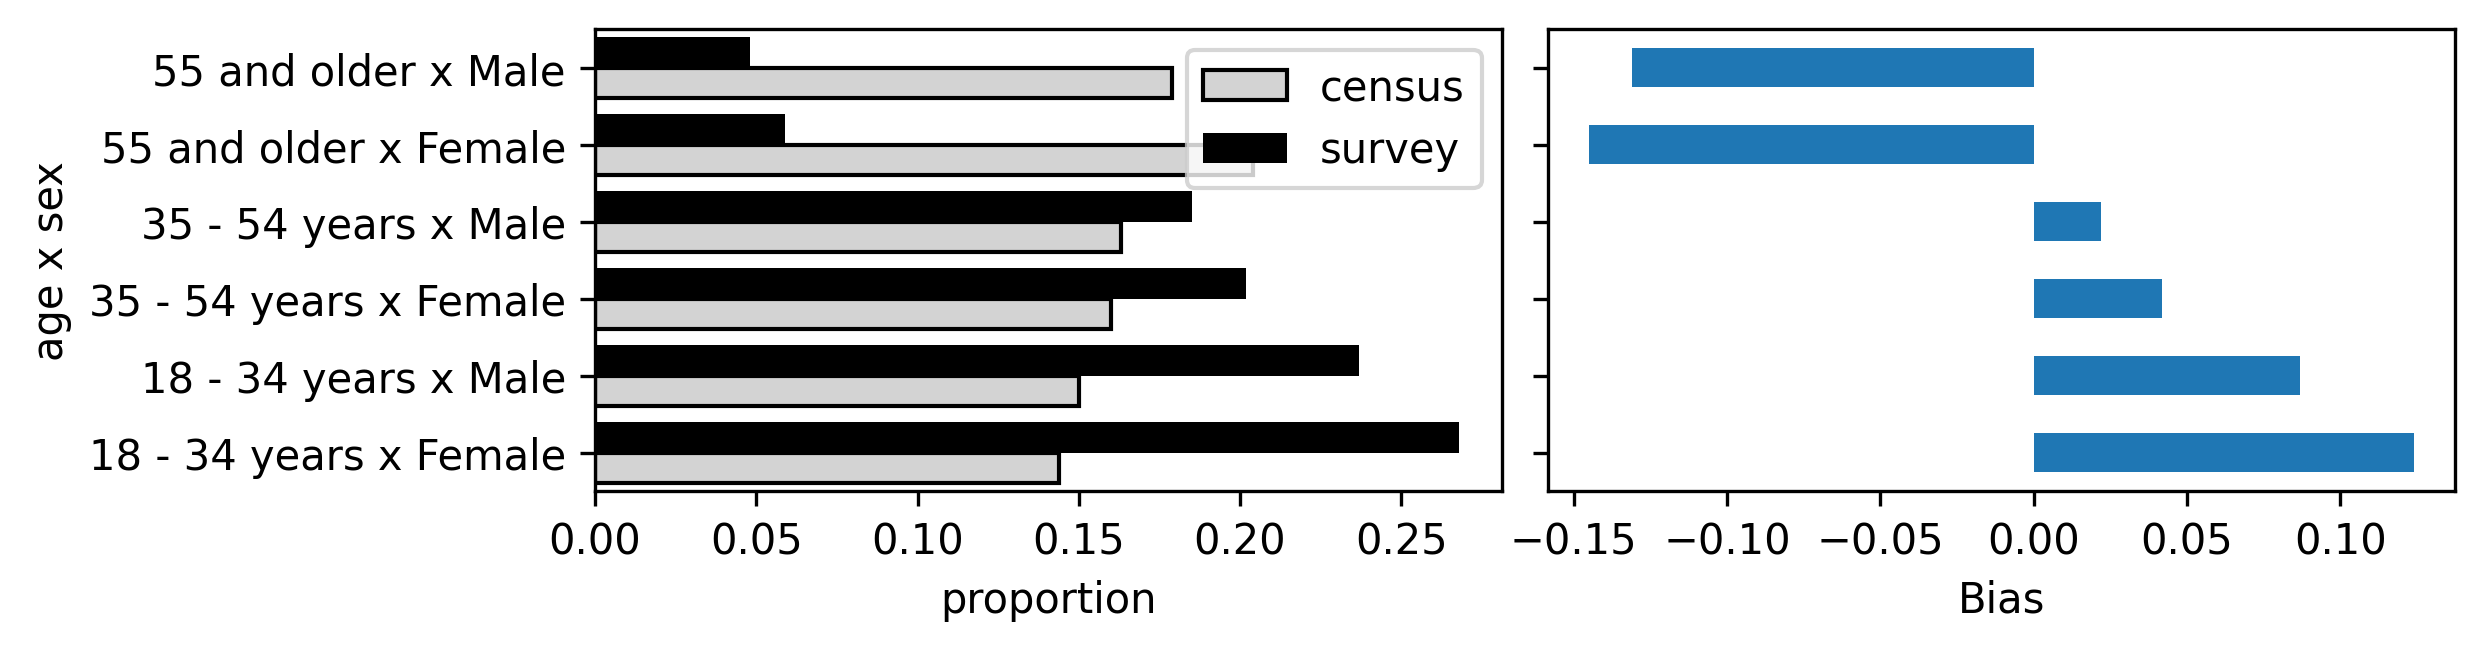

survey N  census N  census proportion   
age x sex                                                       
18 - 34 years x Female      1309  37621213              0.144  \
18 - 34 years x Male        1159  39208218              0.150   
35 - 54 years x Female       987  41727191              0.160   
35 - 54 years x Male         905  42399819              0.163   
55 and older x Female        290  53279042              0.204   
55 and older x Male          237  46601247              0.179   

                        survey proportion census % survey %   bias  
age x sex                                                           
18 - 34 years x Female              0.268    14.4%    26.8%  0.124  
18 - 34 years x Male                0.237    15.0%    23.7%  0.087  
35 - 54 years x Female              0.202    16.0%    20.2%  0.042  
35 - 54 years x Male                0.185    16.3%    18.5%  0.022  
55 and older x Female               0.059    20.4%     5.9% -0.145  
55 and older x Male                 0.048    17.9%     4.8% -0.131

In [60]:
print('Our sampling frame without stratification compared to census data:')
age_sex_df = sampling_frame['age x sex'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_sex_df['census N'] = [
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & (census_age_sex_df['AGE'] >= 55)]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & (census_age_sex_df['AGE'] >= 55)]['N'].sum(),
]
age_sex_df = set_proportions_and_bias(age_sex_df)
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True, dpi=300)
fig.subplots_adjust(wspace=0.05)
plot_census_vs_survey_pops(age_sex_df, ax=ax1)
plot_bias(age_sex_df, ax=ax2)
plt.show()
age_sex_df

In [61]:
stratified_sample_df = get_random_stratified_sample(age_sex_df, sampling_frame)
print('Total stratified sample size n=%s' % len(stratified_sample_df))
stratified_sample_df.head()

using most underrepresented stratum to define strata sizes: 55 and older x Male; max N=237
sampling for N:


age x sex
18 - 34 years x Female    191
18 - 34 years x Male      199
35 - 54 years x Female    212
35 - 54 years x Male      216
55 and older x Female     271
55 and older x Male       237
Name: census N, dtype: int64

Total stratified sample size n=1326


age     sex               age x sex
R_plp4APP7ieUnHfH  18 - 34 years  Female  18 - 34 years x Female
R_2Se2NF3W7re09yf  18 - 34 years  Female  18 - 34 years x Female
R_51FoqOStg2LJqq5  18 - 34 years  Female  18 - 34 years x Female
R_1JRRs0ZhgHAXLPG  18 - 34 years  Female  18 - 34 years x Female
R_O1j7YshNZJCDX9v  18 - 34 years  Female  18 - 34 years x Female

In [62]:
stratified_sample_rids = stratified_sample_df.index
# stratified_sample_rids

# Basic plots for spend

Metrics go until 2022-10 because data collection began 2022-11.

Show total spend per month.

Show total spend per quarter & median spend per user per quarter.

Show median spend per user by demographic group to evaluate whether there are important differences:
- gender
- age
- income

In [63]:
# index for plotting
yyyy_mm_idx = sorted(amzn_df[YYYY_MM].unique())

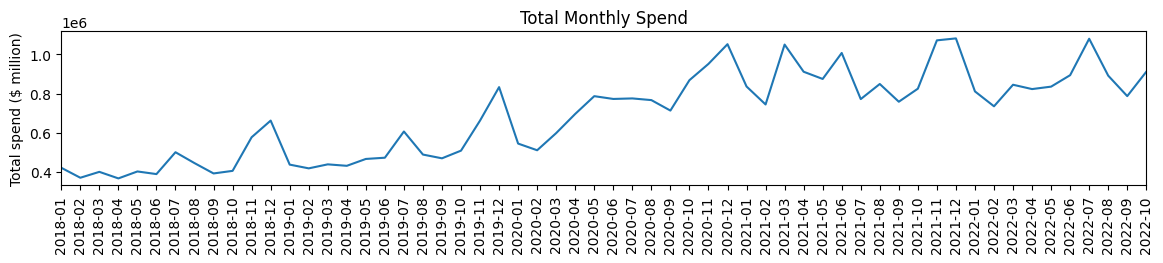

In [64]:
total_spend_m = amzn_df.groupby(YYYY_MM)[TOTAL_SPEND].sum()
ax = plot_monthly_data(total_spend_m)
ax.set_ylabel('Total spend ($ million)')
_ = ax.set_title('Total Monthly Spend')

### Quarterly spend

In [65]:
YEAR_Q_idx = sorted(amzn_df[YEAR_Q].unique())

#### Amazon data

Amazon releases quarterly earnings results. Data are available at https://ir.aboutamazon.com/quarterly-results/default.aspx. 


I compiled data for the North America Segment net sales for each quarter from 2018 Q1 to 2022 Q4 in a spreadsheet here: https://docs.google.com/spreadsheets/d/1ho73vQHHlzJaq9MM63oLCtvtp09p9cqfyGJzmbfpfv8/edit#gid=250251799


In [66]:
# below is copied from the quarterly sales data (see spreadsheet)
# in billions ($)
amzn_quarterly_sales = """30.730
32.170
34.350
44.124
35.812
38.653
42.638
53.670
46.127
55.436
59.373
75.346
64.366
67.550
65.557
82.360
69.244
74.430
78.843
93.363""".split('\n')
amzn_quarterly_sales = pd.Series(amzn_quarterly_sales, index=YEAR_Q_idx).astype(float)

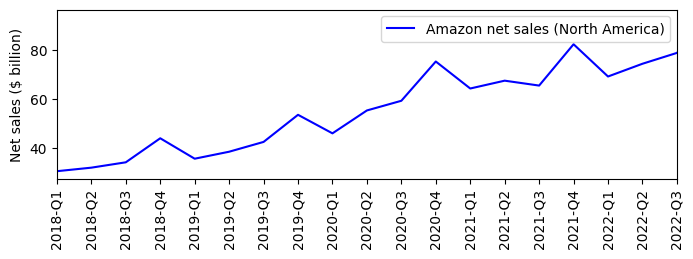

In [67]:
fig, ax = plt.subplots(1,1,figsize=(8,2.2))
ax = plot_monthly_data(amzn_quarterly_sales, xmin='2018-Q1', xmax='2022-Q3', 
                       label='Amazon net sales (North America)', color='blue', ax=ax)
_ = ax.set_ylabel('Net sales ($ billion)')

Compare total spend in our dataset to Amazon quarterly net sales

In [68]:
total_spend_q = amzn_df.groupby(YEAR_Q)[TOTAL_SPEND].sum()

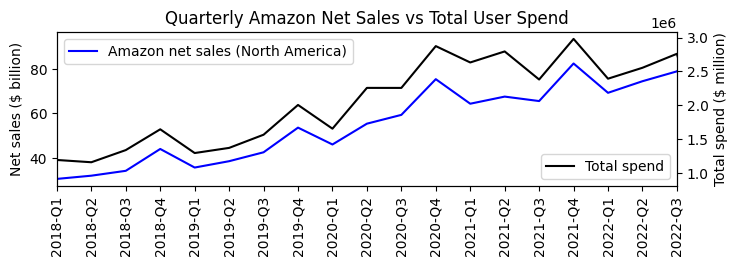

In [69]:
# quarterly spend
fig, ax = plt.subplots(1,1,figsize=(8,2))
ax = plot_monthly_data(amzn_quarterly_sales, xmin='2018-Q1', xmax='2022-Q3', 
                       label='Amazon net sales (North America)', color='blue', ax=ax)
_ = ax.set_ylabel('Net sales ($ billion)')
ax.legend(loc='upper left')
ax = ax.twinx()
ax = plot_monthly_data(total_spend_q, xmin='2018-Q1', xmax='2022-Q3', label='Total spend', color='black', ax=ax)
ax.set_ylabel('Total spend ($ million)')
ax.legend(loc='lower right')
_ = ax.set_title('Quarterly Amazon Net Sales vs Total User Spend')

In [70]:
def get_median_spend_per_rid(df, decimals=2):
    return df.groupby(RESPONSE_ID)[TOTAL_SPEND].sum().median().round(decimals)

def get_quarterly_median_spend_per_rid(df):
    med_spends = [get_median_spend_per_rid(df[df[YEAR_Q]==yq]) for yq in YEAR_Q_idx]
    return pd.Series(med_spends, index=YEAR_Q_idx)

median_spends = get_quarterly_median_spend_per_rid(amzn_df)

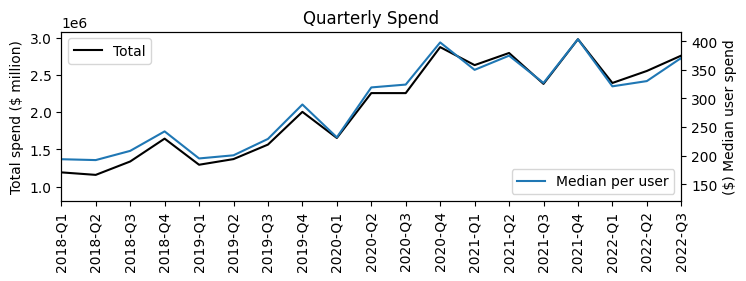

In [71]:
# quarterly spend
fig, ax = plt.subplots(1,1,figsize=(8,2.2))
ax = plot_monthly_data(total_spend_q, xmin='2018-Q1', xmax='2022-Q3', label='Total', color='black', ax=ax)
ax.set_ylabel('Total spend ($ million)')
ax.legend(loc='upper left')
ax2 = ax.twinx()
plot_monthly_data(median_spends, xmin='2018-Q1', xmax='2022-Q3', label='Median per user', ax=ax2)
ax2.legend(loc='lower right')
ax2.set_ylabel('($) Median user spend')
_ = ax.set_title('Quarterly Spend')

Quarterly spend by demographic group

Text(0.5, 1.0, 'Quarterly Median Spend By Gender')

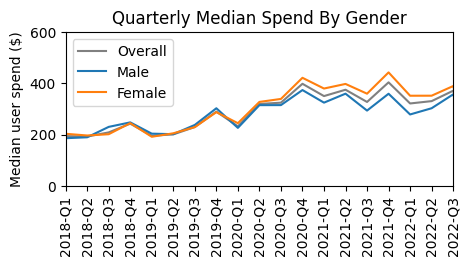

In [72]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
plot_monthly_data(median_spends, xmin='2018-Q1', xmax='2022-Q3', 
                  label='Overall', color='gray', ax=ax)
# By gender (limited to the binary)
genders = ['Male', 'Female']
gender_med_spends = dict()
for gender in genders:
    gdf = amzn_df[amzn_df[RESPONSE_ID].isin(survey_df[survey_df['Q-demos-gender']==gender].index)]
    med_spends = get_quarterly_median_spend_per_rid(gdf)
    gender_med_spends[gender] = med_spends
    plot_monthly_data(med_spends, xmin='2018-Q1', xmax='2022-Q3', label=gender, ax=ax)

ax.set_ylim(0, 600)
_ = ax.set_ylabel('Median user spend ($)')
ax.set_title('Quarterly Median Spend By Gender')

Text(0.5, 1.0, 'Quarterly Median Spend By Age Group')

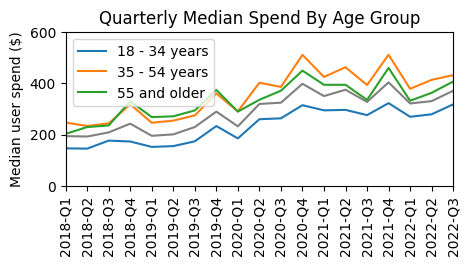

In [73]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
# By age
plot_monthly_data(median_spends, xmin='2018-Q1', xmax='2022-Q3', 
                  color='gray', ax=ax)
ages = sorted(list(set(collapse_age_map.values())))
age_med_spends = dict()
for age in ages:
    df = amzn_df[amzn_df[RESPONSE_ID].isin(survey_df[survey_df['age-collapsed']==age].index)]
    med_spends = get_quarterly_median_spend_per_rid(df)
    age_med_spends[age] = med_spends
    plot_monthly_data(med_spends, xmin='2018-Q1', xmax='2022-Q3', label=age, ax=ax)

ax.set_ylim(0, 600)
_ = ax.set_ylabel('Median user spend ($)')
ax.set_title('Quarterly Median Spend By Age Group')

Text(0.5, 1.0, 'Quarterly Median Spend By Income Group')

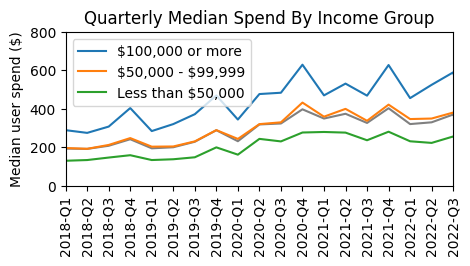

In [74]:
fig, ax = plt.subplots(1,1,figsize=(5,2))
# By income
plot_monthly_data(median_spends, xmin='2018-Q1', xmax='2022-Q3', 
                  color='gray', ax=ax)
incomes = ['$100,000 or more', '\\$50,000 - \\$99,999', 'Less than $50,000']
income_med_spends = dict()
for income in incomes:
    df = amzn_df[amzn_df[RESPONSE_ID].isin(survey_df[survey_df['income-collapsed']==income].index)]
    med_spends = get_quarterly_median_spend_per_rid(df)
    income_med_spends[income] = med_spends
    plot_monthly_data(med_spends, xmin='2018-Q1', xmax='2022-Q3', label=income, ax=ax)
ax.set_ylim(0, 800)
_ = ax.set_ylabel('Median user spend ($)')
ax.set_title('Quarterly Median Spend By Income Group')

Consolidated plot for paper

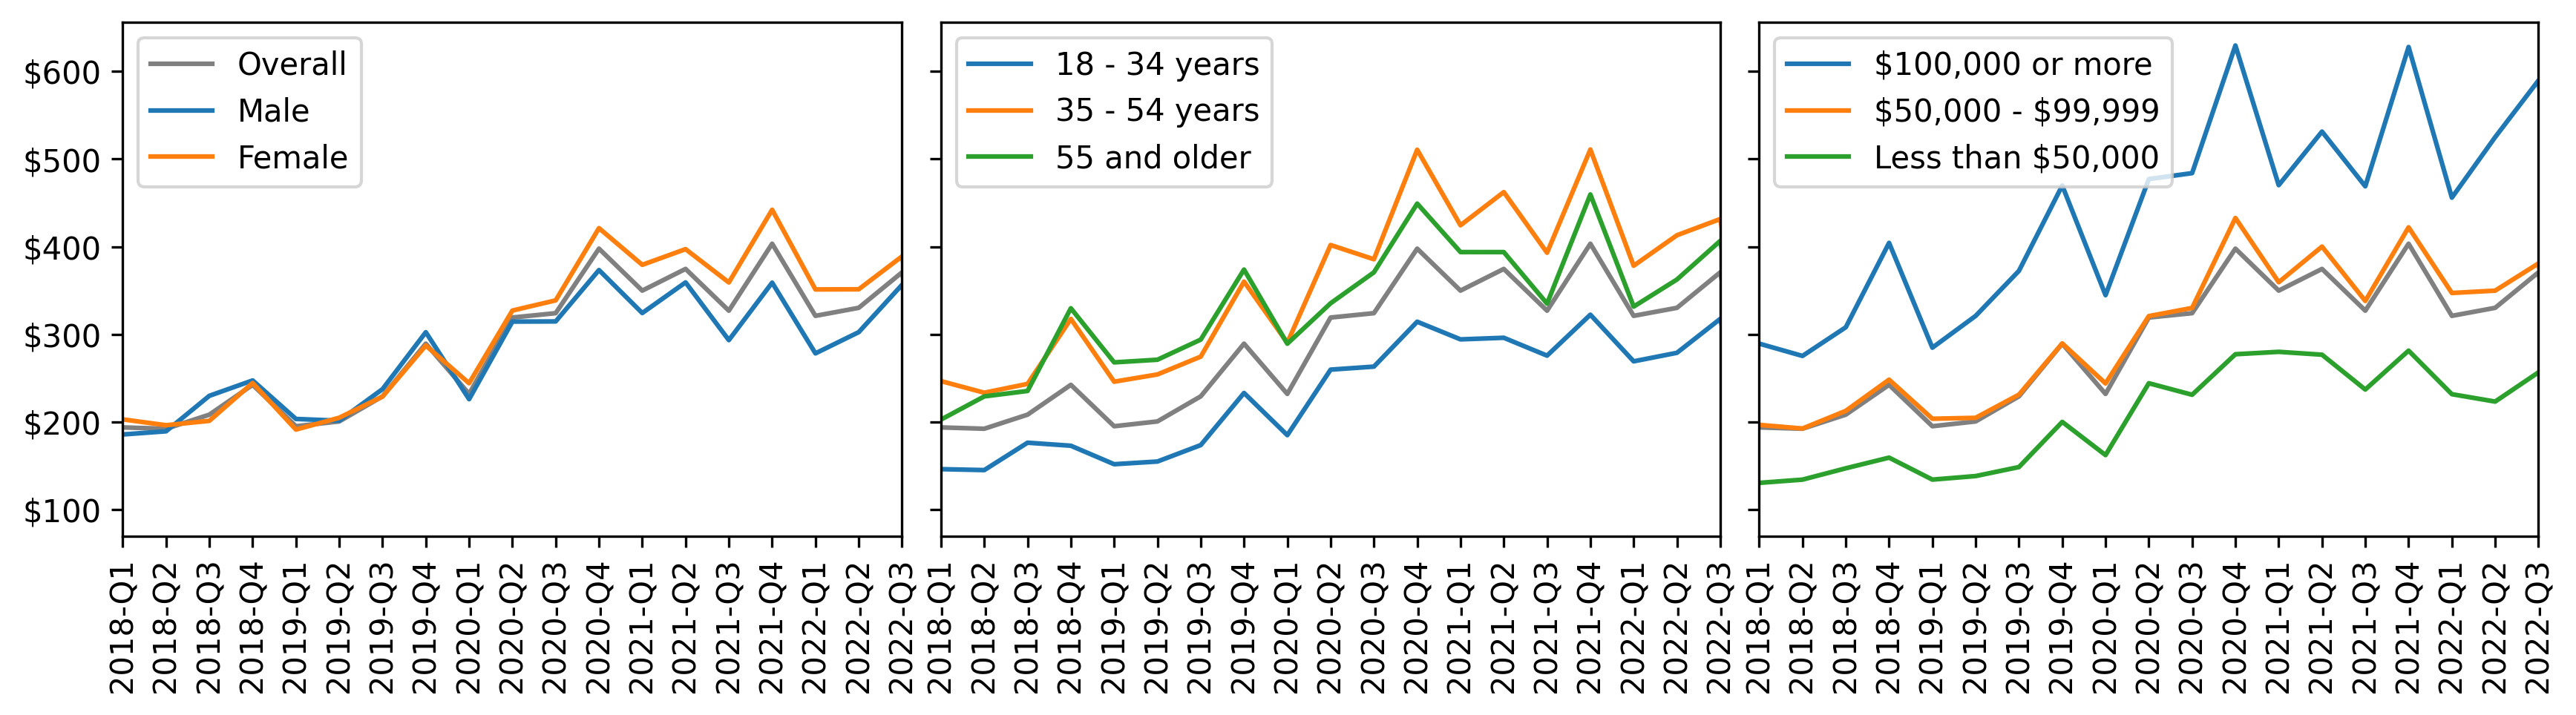

In [75]:
# fig, axes = plt.subplots(3,1,figsize=(5,7), sharex=True, dpi=300)
# fig.subplots_adjust(hspace=0.1)
fig, axes = plt.subplots(1,3,figsize=(14,3), sharex=True, sharey=True, dpi=300)
fig.subplots_adjust(wspace=0.05)
ax = axes[0]
plot_monthly_data(median_spends, xmin='2018-Q1', xmax='2022-Q3', 
                  label='Overall', color='gray', ax=ax)
# By gender (limited to the binary)
genders = ['Male', 'Female']
gender_med_spends = dict()
for gender in genders:
    gdf = amzn_df[amzn_df[RESPONSE_ID].isin(survey_df[survey_df['Q-demos-gender']==gender].index)]
    med_spends = get_quarterly_median_spend_per_rid(gdf)
    gender_med_spends[gender] = med_spends
    plot_monthly_data(med_spends, xmin='2018-Q1', xmax='2022-Q3', label=gender, ax=ax)
ax.legend(loc='upper left')
# By age
ax = axes[1]
plot_monthly_data(median_spends, xmin='2018-Q1', xmax='2022-Q3', color='gray', ax=ax)
ages = sorted(list(set(collapse_age_map.values())))
age_med_spends = dict()
for age in ages:
    df = amzn_df[amzn_df[RESPONSE_ID].isin(survey_df[survey_df['age-collapsed']==age].index)]
    med_spends = get_quarterly_median_spend_per_rid(df)
    age_med_spends[age] = med_spends
    plot_monthly_data(med_spends, xmin='2018-Q1', xmax='2022-Q3', label=age, ax=ax)
ax.legend(loc='upper left')
# By income
ax = axes[2]
plot_monthly_data(median_spends, xmin='2018-Q1', xmax='2022-Q3', color='gray', ax=ax)
incomes = ['$100,000 or more', '\\$50,000 - \\$99,999', 'Less than $50,000']
income_med_spends = dict()
for income in incomes:
    df = amzn_df[amzn_df[RESPONSE_ID].isin(survey_df[survey_df['income-collapsed']==income].index)]
    med_spends = get_quarterly_median_spend_per_rid(df)
    income_med_spends[income] = med_spends
    plot_monthly_data(med_spends, xmin='2018-Q1', xmax='2022-Q3', label=income, ax=ax)

for ax in axes:
    ax.yaxis.set_major_formatter('${x:1.0f}')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

Clearly there are differences in spending patterns by demographic group. 

--> Use stratified sample.

In [76]:
ss_amzn_df = amzn_df[amzn_df[RESPONSE_ID].isin(stratified_sample_rids)]
print('Amazon data using stratified sample:')
print_data_metrics(ss_amzn_df)
# ss_amzn_df.head(2)

Amazon data using stratified sample:
476465 purchases
1326 response Ids


In [77]:
# quarterly spend - stratified sample
ss_total_spend_q = ss_amzn_df.groupby(YEAR_Q)[TOTAL_SPEND].sum()

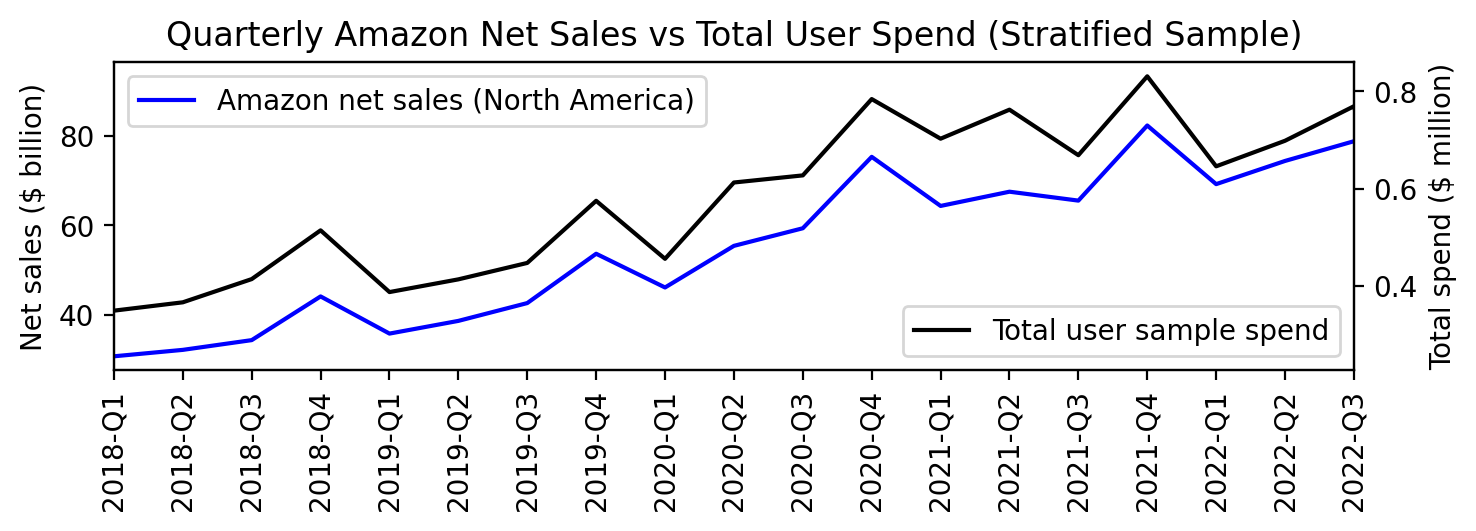

In [78]:
fig, ax = plt.subplots(1,1,figsize=(8,2), dpi=200)
ax = plot_monthly_data(amzn_quarterly_sales, xmin='2018-Q1', xmax='2022-Q3', 
                       label='Amazon net sales (North America)', color='blue', ax=ax)
_ = ax.set_ylabel('Net sales ($ billion)')
ax.legend(loc='upper left')
ax = ax.twinx()
ax = plot_monthly_data(ss_total_spend_q/1000000, xmin='2018-Q1', xmax='2022-Q3', label='Total user sample spend', color='black', ax=ax)
ax.set_ylabel('Total spend ($ million)')
ax.legend(loc='lower right')
_ = ax.set_title('Quarterly Amazon Net Sales vs Total User Spend (Stratified Sample)')

Top: without stratified sample (n=5014); Bottom: with stratified sample (n=1326)


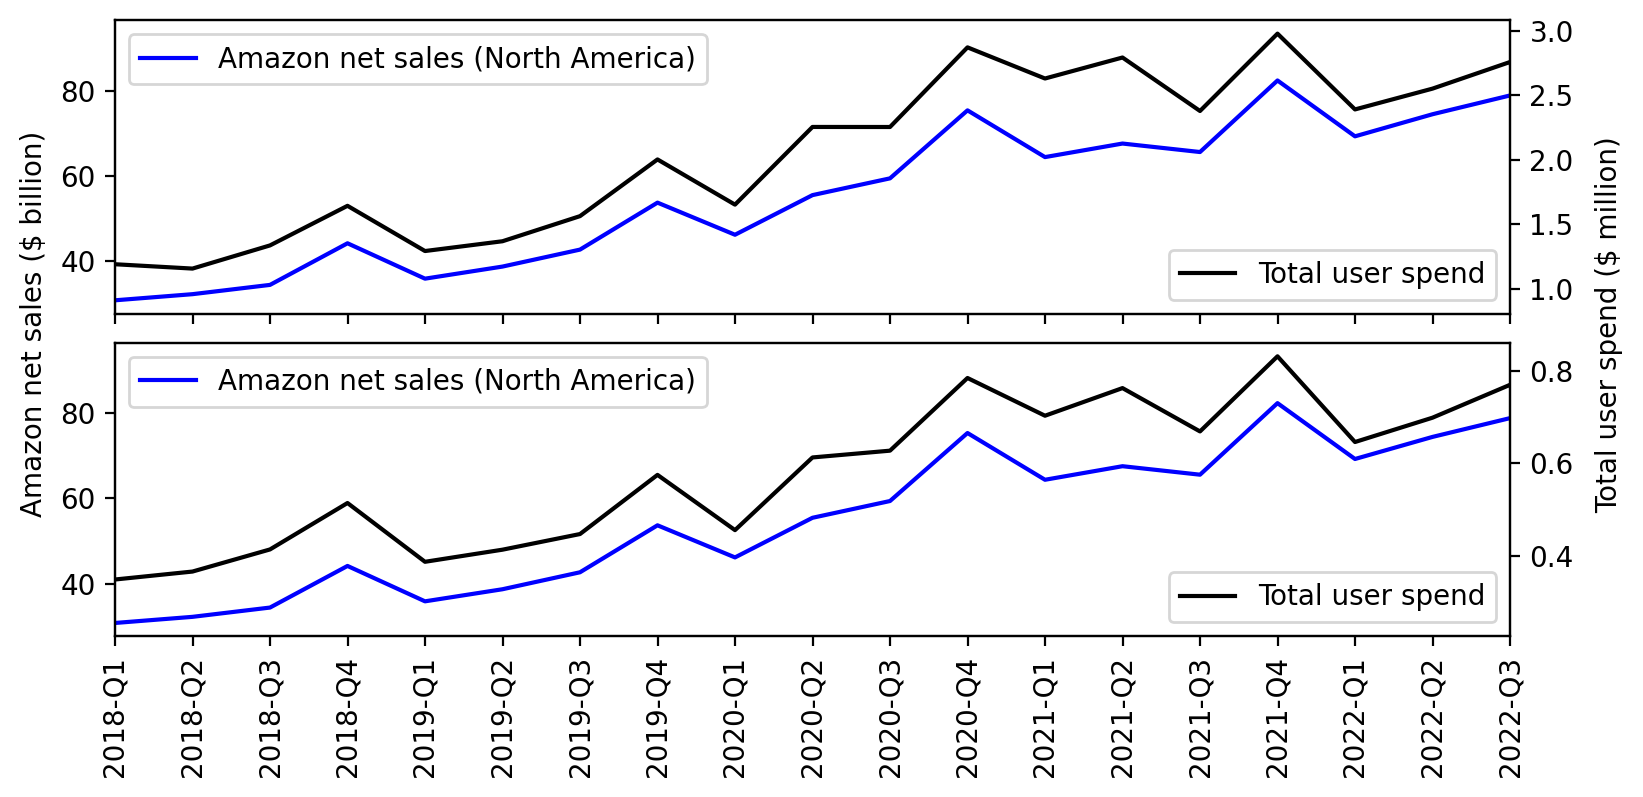

In [79]:
# Put a plot with a stratified sample in the same panel as without stratified sample
print('Top: without stratified sample (n=%s); Bottom: with stratified sample (n=%s)' % (
    amzn_df[RESPONSE_ID].nunique(), len(stratified_sample_rids),
))
fig, axes = plt.subplots(2,1,figsize=(9,4), dpi=200, sharex=True)
fig.subplots_adjust(hspace=0.1)
ylabel_left = 'Amazon net sales ($ billion)'
ylabel_right = 'Total user spend ($ million)'
ax = axes[0]
# _ = ax.set_title('Quarterly Amazon Net Sales vs Total User Spend')
plot_monthly_data(amzn_quarterly_sales, xmin='2018-Q1', xmax='2022-Q3', 
                       label='Amazon net sales (North America)', color='blue', ax=ax)
ax.legend(loc='upper left')
ax = ax.twinx()
plot_monthly_data(total_spend_q/1000000, xmin='2018-Q1', xmax='2022-Q3', color='black', ax=ax, 
                  label='Total user spend')
ax.legend(loc='lower right')

ax=axes[1]
plot_monthly_data(
    amzn_quarterly_sales, xmin='2018-Q1', xmax='2022-Q3', color='blue', ax=ax, 
    label='Amazon net sales (North America)'
)
ax.legend(loc='upper left')
ax = ax.twinx()
plot_monthly_data(
    ss_total_spend_q/1000000, xmin='2018-Q1', xmax='2022-Q3', color='black', ax=ax, 
    label='Total user spend'
)
# set ylabels common to two subplots
fig.text(0.08, 0.5, ylabel_left, ha='center', va='center', rotation='vertical')
fig.text(0.955, 0.5, ylabel_right, ha='center', va='center', rotation='vertical')
_ = ax.legend(loc='lower right')

#### Statistical comparison of Amazon net sales to total user spend

Comparing by quarter

- Pearson correlation
- linear regression

without stratified sample (n=5014)
Pearson r=0.978, p=0.000
with stratified sample (n=1326)
Pearson r=0.977, p=0.000


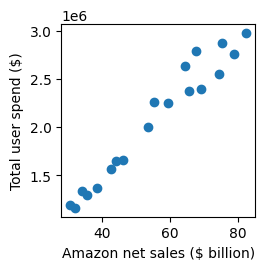

In [80]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.scatter(amzn_quarterly_sales.loc[:'2022-Q3'], total_spend_q.loc[:'2022-Q3'])
ax.set_xlabel('Amazon net sales ($ billion)')
ax.set_ylabel('Total user spend ($)')
print('without stratified sample (n=%s)' % amzn_df[RESPONSE_ID].nunique())
(r, pvalue) = pearsonr(amzn_quarterly_sales.loc[:'2022-Q3'], total_spend_q.loc[:'2022-Q3'])
print('Pearson r=%0.3f, p=%.3f' % (r, pvalue))
print('with stratified sample (n=%s)' % ss_amzn_df[RESPONSE_ID].nunique())
(r, pvalue) = pearsonr(amzn_quarterly_sales.loc[:'2022-Q3'], ss_total_spend_q.loc[:'2022-Q3'])
print('Pearson r=%0.3f, p=%.3f' % (r, pvalue))

### Product / category specific analysis

#### Seasonality in footwear purchases

We might expect boots to be bought more in winter vs sandals bought more in summer.

Without stratified sample:


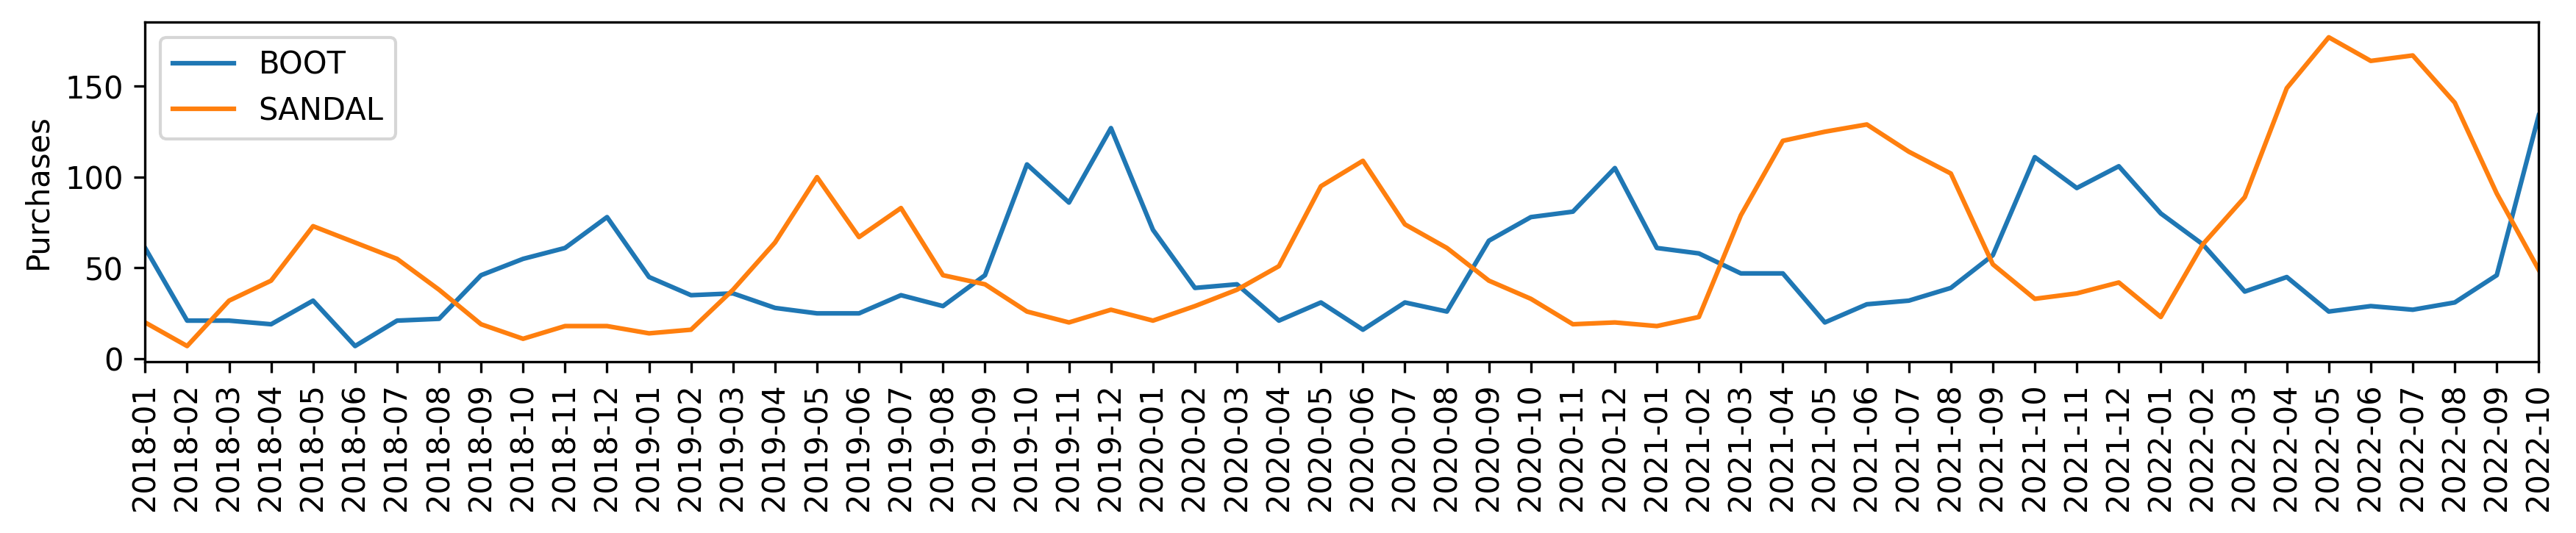

With stratified sample:


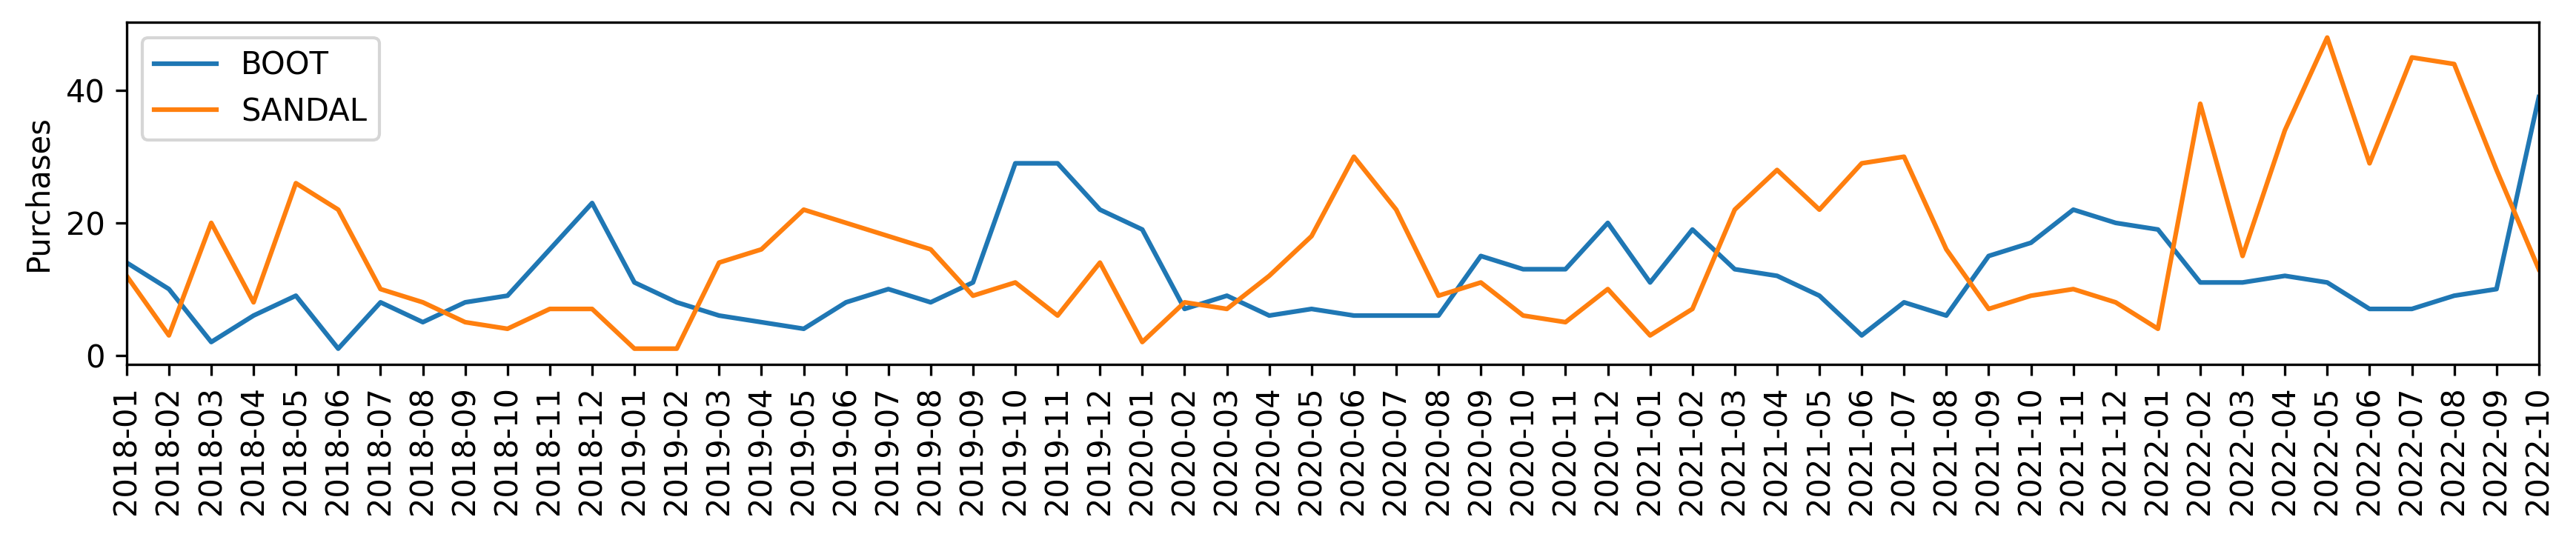

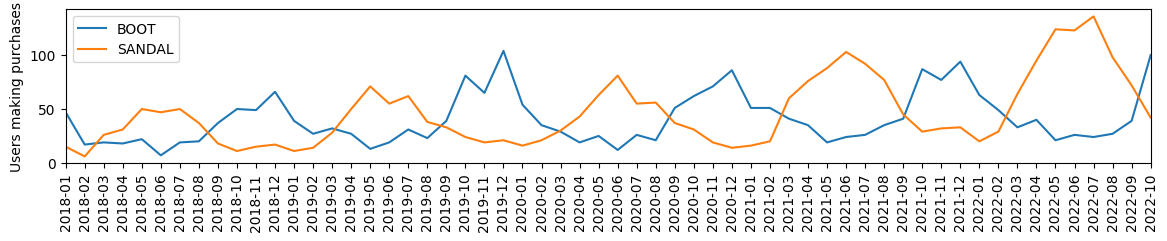

In [81]:
# get footwear categories of interest
footwear_categories = [
    'BOOT', 'SANDAL',
    # Note there are also: 
    # 'SLIPPER', Slippers peak at December
    #'SHOES', 'TECHNICAL_SPORT_SHOE',
]
print('Without stratified sample:')
fig, ax = plt.subplots(1,1,figsize=(14,2), dpi=300)
ax.set_ylabel('Purchases')
for cat in footwear_categories:
    purchases = amzn_df[amzn_df[CATEGORY]==cat].groupby(YYYY_MM)[QUANTITY].sum()
    plot_monthly_data(purchases, label=cat, ax=ax)
plt.show()
print('With stratified sample:')
fig, ax = plt.subplots(1,1,figsize=(14,2), dpi=300)
ax.set_ylabel('Purchases')
for cat in footwear_categories:
    purchases = ss_amzn_df[ss_amzn_df[CATEGORY]==cat].groupby(YYYY_MM)[QUANTITY].sum()
    plot_monthly_data(purchases, label=cat, ax=ax)
plt.show()
fig, ax = plt.subplots(1,1,figsize=(14,2))
ax.set_ylabel('Users making purchases')
for cat in footwear_categories:
    purchases = amzn_df[amzn_df[CATEGORY]==cat].groupby(YYYY_MM)[RESPONSE_ID].nunique()
    plot_monthly_data(purchases, label=cat, ax=ax)

### Books

The census conducts a Monthly Retail Trade Survey
from which we downloaded the retail book store sales.

Copied into spreadsheet [here](https://docs.google.com/spreadsheets/d/1fYT2jK75SeJM_xEys765nqnnV5xvkN2SC0wpvNgH-IE/edit?usp=sharing).

Citation: 
> U.S. Census Bureau, Retail Sales: Book Stores [MRTSSM451211USN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MRTSSM451211USN, November 6, 2023. 


In [82]:
# sales are in millions of dollars
retail_sales_bookstores = """1207
634
652
624
691
632
605
1214
863
637
664
1121
1006
574
593
639
685
604
581
1107
856
637
627
1050
967
575
393
171
263
369
415
729
583
425
461
834
754
415
493
459
563
624
630
1018
777
612
621
1051
803
513
535
585
613
560
595
1055
799
587""".split('\n')
retail_sales_bookstores = pd.Series(retail_sales_bookstores, index=yyyy_mm_idx).astype(float)

82954 book purchases from N=4180 users
With stratified sample:
22009 book purchases from N=1116 users
Pearson correlation (r, pvalue): (0.911, 0.000)


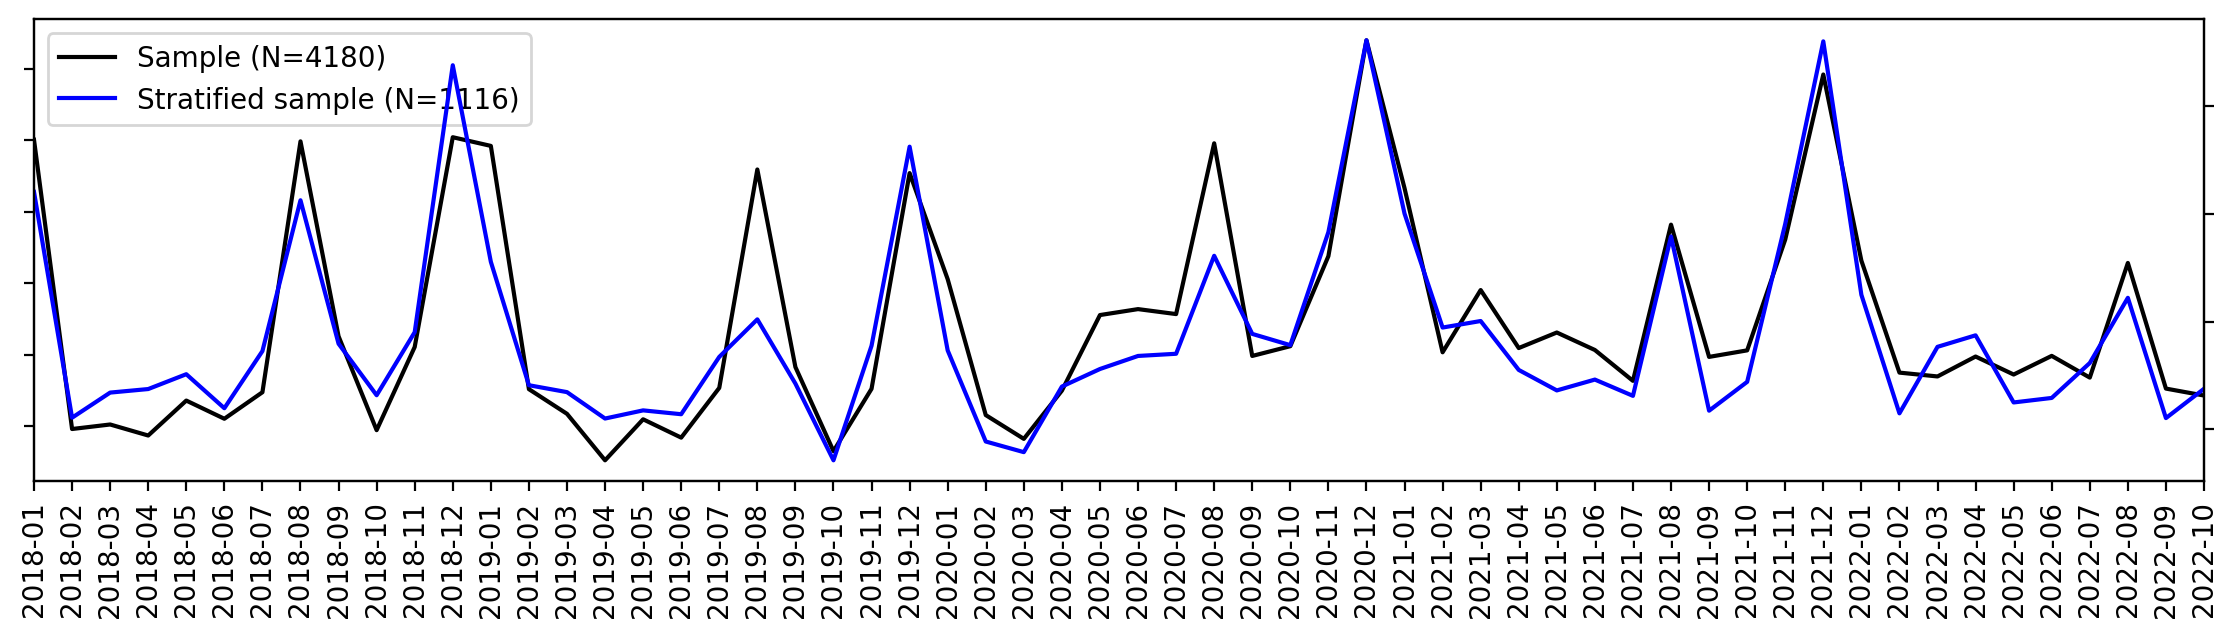

In [83]:
# Get user book purchases spend
book_categories = ['ABIS_BOOK', 'BOOK', 'BOOKS_1973_AND_LATER']
book_purchases = amzn_df[amzn_df['Category'].isin(book_categories)]
print('%s book purchases from N=%s users' % (len(book_purchases), book_purchases[RESPONSE_ID].nunique()))
book_purchases_m = book_purchases.groupby(YYYY_MM)[TOTAL_SPEND].sum()
# with stratified sample:
print('With stratified sample:')
ss_book_purchases = ss_amzn_df[ss_amzn_df['Category'].isin(book_categories)]
print('%s book purchases from N=%s users' % (len(ss_book_purchases), ss_book_purchases[RESPONSE_ID].nunique()))
ss_book_purchases_m = ss_book_purchases.groupby(YYYY_MM)[TOTAL_SPEND].sum()
(r, pvalue) = pearsonr(book_purchases_m, ss_book_purchases_m)
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
fig, ax = plt.subplots(1,1, figsize=(14,3), dpi=200)
plot_monthly_data(
    book_purchases_m, color='black', legend=False,
    ax=ax, label='Sample (N=%s)'%book_purchases[RESPONSE_ID].nunique()
)
ax2 = ax.twinx()
_ = plot_monthly_data(
    ss_book_purchases_m, color='blue', legend=False,
    ax=ax2, label='Stratified sample (N=%s)'%ss_book_purchases[RESPONSE_ID].nunique()
)
_ = ax.legend(handles=[ax.get_lines()[0], ax2.get_lines()[0]])
ax.set_yticklabels([])
_ = ax2.set_yticklabels([])

Without stratified sample:


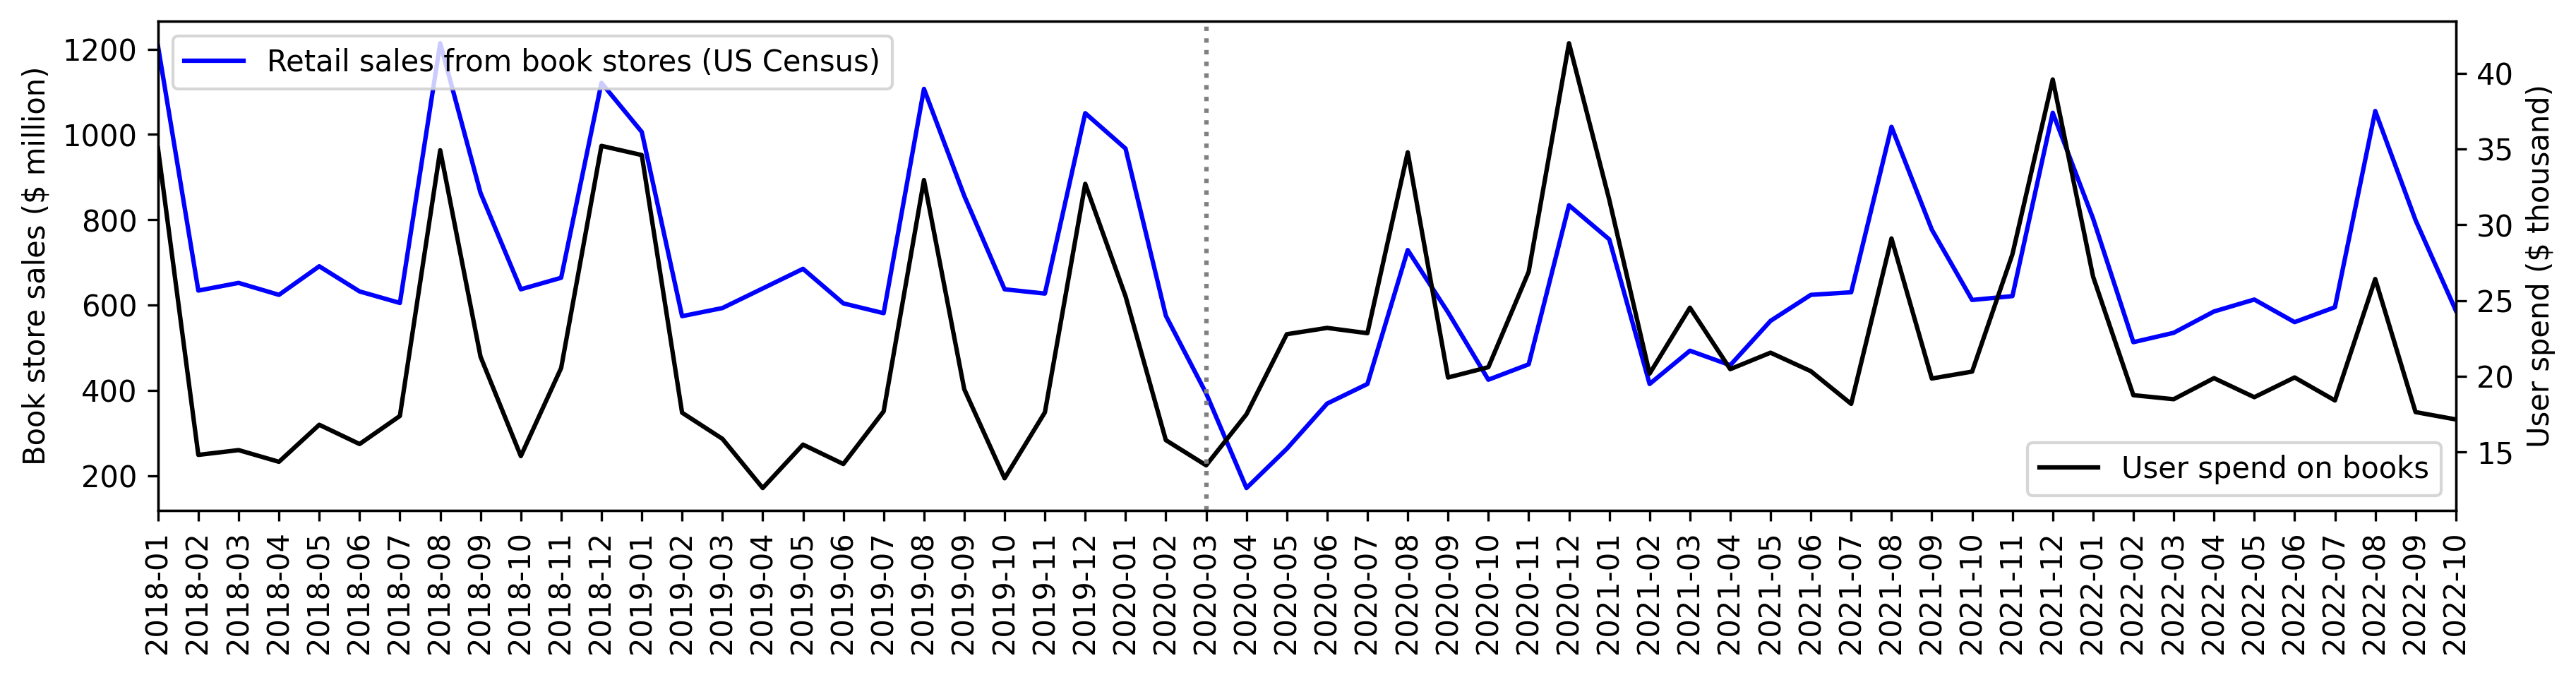

In [84]:
print('Without stratified sample:')
fig, ax = plt.subplots(1,1,figsize=(14,3), dpi=300)
ax.set_ylabel('Book store sales ($ million)')
plot_monthly_data(
    retail_sales_bookstores, ax=ax,
    label='Retail sales from book stores (US Census)', color='blue')
ax.legend(loc='upper left')
ax = ax.twinx()
ax.set_ylabel('User spend ($ thousand)')
plot_monthly_data(book_purchases_m/1000, ax=ax, 
                  label='User spend on books', color='black', show_covid=True)
_ = ax.legend(loc='lower right')

With stratified sample:


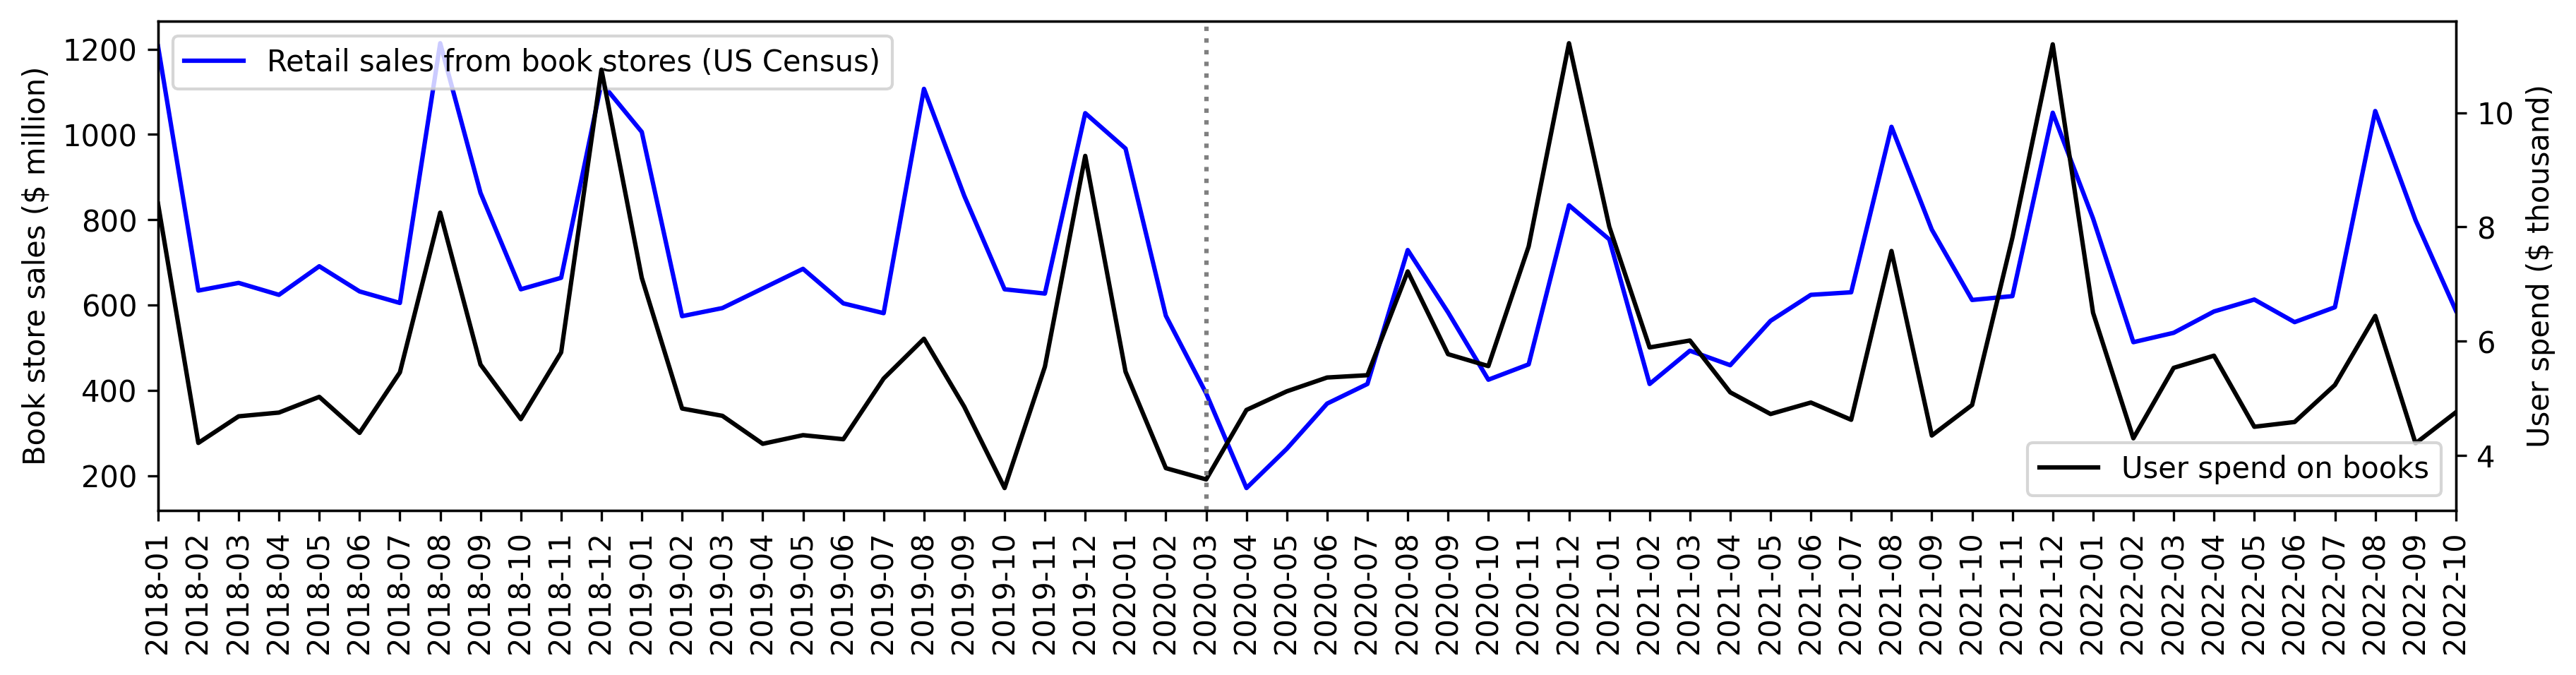

In [85]:
print('With stratified sample:')
fig, ax = plt.subplots(1,1,figsize=(14,3), dpi=300)
ax.set_ylabel('Book store sales ($ million)')
plot_monthly_data(
    retail_sales_bookstores, ax=ax,
    label='Retail sales from book stores (US Census)', color='blue')
ax.legend(loc='upper left')
ax = ax.twinx()
ax.set_ylabel('User spend ($ thousand)')
plot_monthly_data(ss_book_purchases_m/1000, ax=ax, 
                  label='User spend on books', color='black', show_covid=True)
_ = ax.legend(loc='lower right')

#### Regression analysis for books

retail_sales ~ intercept + user_books_spend + post_covid

or

retail_sales ~ intercept + user_books_spend + post_covid + covid_recession 

According to the National Bureau of Economic Research, the acknowledged arbiter of business-cycle dating, the contraction in economic activity marking the pandemic recession lasted only two months: March and April 2020.

For this rason we add an indicator variable: `covid_recession`

We define:
- `covid_recession`: 1 for 2020-03 and 2020-04, 0 otherwise
- `post_covid`: 0 before 2020-03, 1 otherwise

Data are scaled such that retail sales are in the millions and user spend data are in the thousands ($).

In [86]:
data = pd.DataFrame({
    'retail_sales': retail_sales_bookstores,
    'user_books_spend': book_purchases_m/1000,
    'ss_user_books_spend': ss_book_purchases_m/1000, # stratified sample
    'covid_recession': [(1 if ym in ['2020-03', '2020-04'] else 0) for ym in yyyy_mm_idx],
    'post_covid': [(0 if ym < '2020-03' else 1) for ym in yyyy_mm_idx],
})
data.head(3)

retail_sales  user_books_spend  ss_user_books_spend  covid_recession   
2018-01        1207.0          35.03164              8.40658                0  \
2018-02         634.0          14.80770              4.21799                0   
2018-03         652.0          15.12375              4.68394                0   

         post_covid  
2018-01           0  
2018-02           0  
2018-03           0

In [87]:
# formula = 'retail_sales ~ user_books_spend + covid_recession + post_covid' # R2=0.648
formula = 'retail_sales ~ user_books_spend + post_covid' # R2=0.63
# formula = 'retail_sales ~ ss_user_books_spend + post_covid' # R2=0.555
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Formula:
retail_sales ~ user_books_spend + post_covid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           retail_sales   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     46.75
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           1.37e-12
Time:                        18:03:33   Log-Likelihood:                -367.66
No. Observations:                  58   AIC:                             741.3
Df Residuals:                      55   BIC:                             747.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          306.0007     60.975      5.018      0.000     183.804     428.197
user_books_spend    22.3666      2.616      8.551      0.000      17.125      27.609
post_covid        -220.0748     37.648     -5.846      0.000    -295.522    -144.627
==============================================================================
Omnibus:                        1.867   Durbin-Watson:                   0.688
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.106
Skew:                           0.139   Prob(JB):                        0.575
Kurtosis:                       3.617   Cond. No.                         77.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
print('Robustness test: using stratified sample')
formula = 'retail_sales ~ ss_user_books_spend + post_covid' # R2=0.555
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Robustness test: using stratified sample
Formula:
retail_sales ~ ss_user_books_spend + post_covid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           retail_sales   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     29.31
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           2.16e-09
Time:                        18:03:33   Log-Likelihood:                -375.42
No. Observations:                  58   AIC:                             756.8
Df Residuals:                      55   BIC:                             763.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             330.2373     74.222      4.449      0.000     181.493     478.982
ss_user_books_spend    78.9511     12.036      6.560      0.000      54.831     103.071
post_covid           -192.2950     42.631     -4.511      0.000    -277.729    -106.861
==============================================================================
Omnibus:                        1.907   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.385   Jarque-Bera (JB):                1.507
Skew:                           0.395   Prob(JB):                        0.471
Kurtosis:                       3.008   Cond. No.                         22.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Face masks & COVID-19


Here we:
- collect purchases for face masks
- include COVID-19 data for US (entire US)
- aggregate data to month

#### COVID-19 data


COVID-19 data are downloaded from the WHO website: 
https://covid19.who.int/data 
Download link: https://covid19.who.int/WHO-COVID-19-global-data.csv
I put data in a spreadsheet [here](https://docs.google.com/spreadsheets/d/1Hu3PgjXVpMbtMcFOKtxCgfWnGn3995mdid7XPlDuxo0/edit?usp=sharing) and filtered to United States of America with relevant dates.


In [89]:
covid_data = pd.read_csv('../data/validation-data/COVID19-US-WHO.csv', parse_dates=['Date_reported'])
# add year-month column
covid_data[YYYY_MM] = covid_data['Date_reported'].apply(lambda d: date.strftime(d, '%Y-%m'))
covid_data.head(3)

Date_reported Country_code                   Country  New_cases  New_deaths   
0    2020-01-03           US  United States of America          0           0  \
1    2020-01-04           US  United States of America          0           0   
2    2020-01-05           US  United States of America          0           0   

   yyyy-mm  
0  2020-01  
1  2020-01  
2  2020-01

In [90]:
# aggregate data to month
covid_data_m = covid_data.groupby(YYYY_MM)[['New_cases', 'New_deaths']].sum()
display(covid_data_m.head())

New_cases  New_deaths
yyyy-mm                       
2020-01          8           0
2020-02         61           1
2020-03     173074        3326
2020-04     857163       57134
2020-05     755116       44864

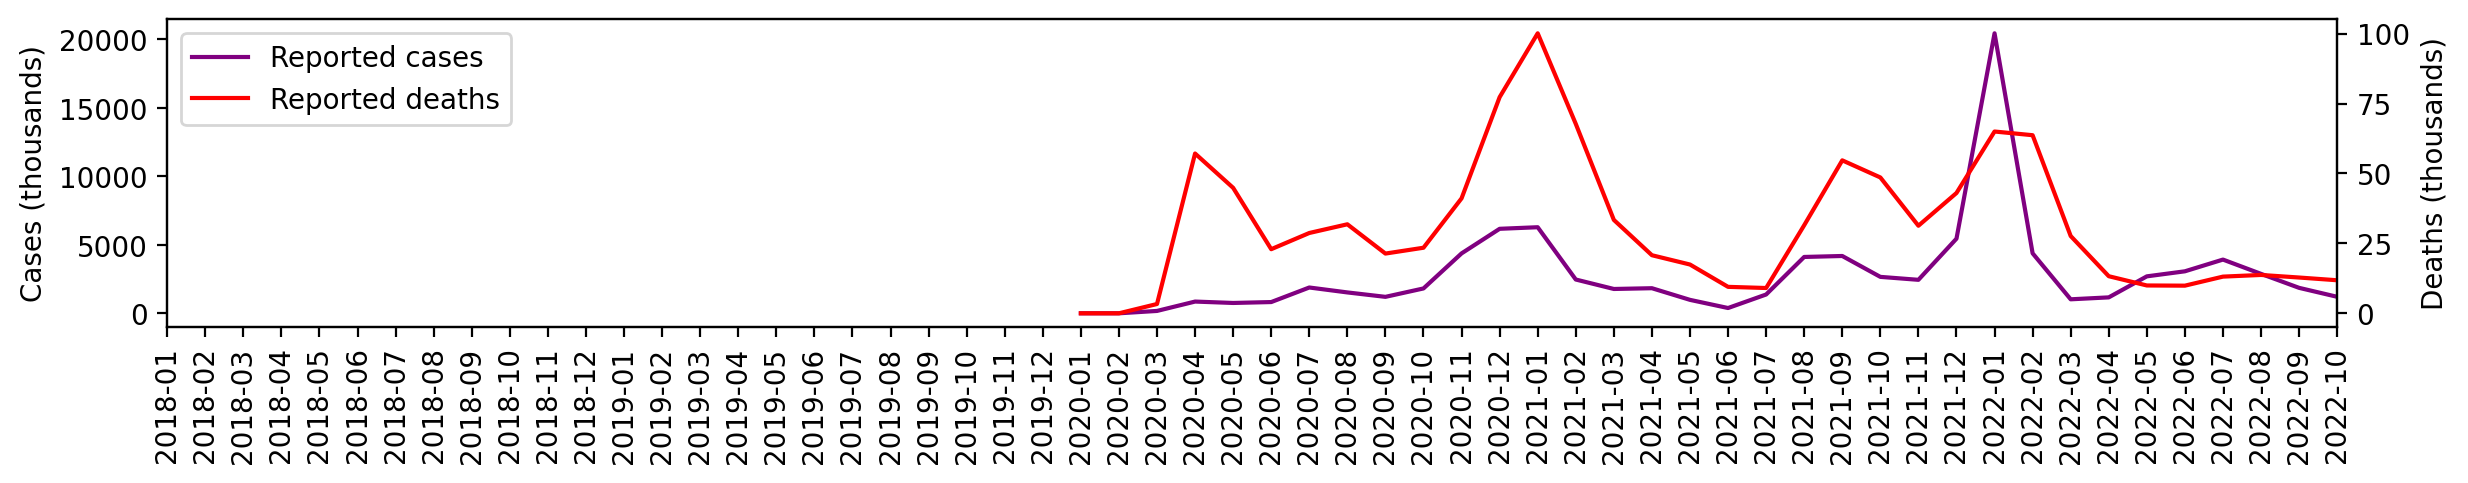

In [91]:
# plot it - reindex to match purchases data
fig, ax = plt.subplots(1,1,figsize=(14,2), dpi=200)
plot_monthly_data(covid_data_m['New_cases'].reindex(yyyy_mm_idx)/1000, ax=ax, 
                  label='Reported cases', color='purple', legend=False)
ax.legend(loc='upper left')
ax.set_ylabel('Cases (thousands)')
ax2 = ax.twinx()
plot_monthly_data(covid_data_m['New_deaths'].reindex(yyyy_mm_idx)/1000, ax=ax2, 
                     color='red', label='Reported deaths', legend=False)
ax2.set_ylabel('Deaths (thousands)')

_ = ax.legend(handles=[ax.get_lines()[0], ax2.get_lines()[0]])

#### Face masks

Find the face masks. This doesn't need to be exhaustive. The point is to find the trends.

Note:
- There are items in category SAFETY_MASK that seem like COVID related masks but do not have 'face mask' in the title.
- 'facial mask's are sometimes in the SAFETY_MASK category

Define the mask item criteria:

- Include all items in the below categories that have titles meeting criteria:
    - contain 'face mask' or 'kf94' or ('n95' and 'mask') 
    - does not contain 'facial', 'party', 'costume'

categories for inclusion:

'SAFETY_MASK',
'RESPIRATOR',
'APPAREL_HEAD_NECK_COVERING',
'HAT',
'PROFESSIONAL_HEALTHCARE',
'SPORT_FACE_MASK',
'SAFETY_SUPPLY',
'FACE_SHIELD',
'LAB_SUPPLY'

In [92]:
print([c for c in list(amzn_df['Category'].unique()) if 'mask' in str(c).lower()])

['SKIN_TREATMENT_MASK', 'SAFETY_MASK', 'SAFETY_MASK_STRAP_EXTENDER', 'COSTUME_MASK', 'SLEEP_MASK', 'SAFETY_MASK_REPLACEMENT_FILTER', 'DIVE_MASK', 'SPORT_FACE_MASK']


In [93]:
# what are the safety masks that do not have 'face mask' in the title?
safety_masks = amzn_df[amzn_df['Category']=='SAFETY_MASK']
print('%s purchases in category SAFETY_MASK; %s unique titles' % (len(safety_masks), safety_masks['Title'].nunique()))
safety_masks_without_face_mask = safety_masks[
    safety_masks['Title'].apply(lambda t: 'face mask' not in str(t).lower())
]
print('%s SAFETY_MASK purchases do not have face mask in the title. Examples:' % len(safety_masks_without_face_mask))
safety_masks_without_face_mask.groupby(
    'Title'
)['Quantity'].agg(['count','sum']).sort_values('count', ascending=False).head(5)

4792 purchases in category SAFETY_MASK; 2130 unique titles
1035 SAFETY_MASK purchases do not have face mask in the title. Examples:


count   
Title                                                                                                                                                 
Pack 3 Dust Mouth Cover - All Cotton - Reusable Cloth Comfy Breathable Material                                                                  22  \
SOOQOO Masks Disposable 100Pcs,with Elastic Loop, Breathable Comfort, 3-Ply Masks, Waterproof, Adjustable Clip, Skin-Friendly Fabric (Black)     22   
2-Pack Unisex Cloth Washable Reusable Cover-100% Cotton 3 Layer black outdoor                                                                    20   
Cotton Cute Mouth Face Mouth Cover- Reusable Cotton Comfy Breathable Outdoor Fashion Face Protections Man and Woman                              19   
5PCS black unisex can reuse Cloth                                                                                                                13   

                                                                                                                                               sum  
Title                                                                                                                                               
Pack 3 Dust Mouth Cover - All Cotton - Reusable Cloth Comfy Breathable Material                                                               24.0  
SOOQOO Masks Disposable 100Pcs,with Elastic Loop, Breathable Comfort, 3-Ply Masks, Waterproof, Adjustable Clip, Skin-Friendly Fabric (Black)  25.0  
2-Pack Unisex Cloth Washable Reusable Cover-100% Cotton 3 Layer black outdoor                                                                 20.0  
Cotton Cute Mouth Face Mouth Cover- Reusable Cotton Comfy Breathable Outdoor Fashion Face Protections Man and Woman                           21.0  
5PCS black unisex can reuse Cloth                                                                                                             15.0

In [94]:
titles = amzn_df[TITLE].unique()

In [95]:
mask_titles = set([t for t in titles if 'face mask' in str(t).lower()])
mask_titles.update({t for t in titles if 'facemask' in str(t).lower()})
mask_titles.update({t for t in titles if 'kn95' in str(t).lower()})
mask_titles.update({t for t in titles if 'kf94' in str(t).lower()})
mask_titles.update({t for t in titles if ('n95' in str(t).lower()) and ('mask' in str(t).lower())})
mask_titles = mask_titles - {t for t in titles if 'facial' in str(t).lower()}
mask_titles = mask_titles - {t for t in titles if 'party' in str(t).lower()}
mask_titles = mask_titles - {t for t in titles if 'costume' in str(t).lower()}
print('%s different item KF94 / N95 / face mask titles, excluding facial masks' % len(mask_titles))
mask_purchases_df = amzn_df[amzn_df['Title'].isin(mask_titles)]
print('%s purchases with relevant face mask titles' % len(mask_purchases_df))
print('Most popular:')
mask_purchases_df.groupby(
    [TITLE, CATEGORY]
)[QUANTITY].agg(['sum','count']).sort_values('count', ascending=False).head(10)

2631 different item KF94 / N95 / face mask titles, excluding facial masks
6219 purchases with relevant face mask titles
Most popular:


sum   
Title                                                                                                         Category                        
100PCS 3 Ply Black Disposable Face Mask Filter Protection Face Masks                                          SAFETY_MASK              90.0  \
Black Disposable Face Masks, Black Face Masks 3 Ply Filter Protection                                         SAFETY_MASK              53.0   
SupplyAID RRS-KN95-5PK KN95 Face Mask for Protection Against PM2.5 Dust, Pollen and Haze-Proof, 5 Pack, White RESPIRATOR               61.0   
100Pcs Disposable Face Masks, Black Face Mask, 3 Ply Disposable Mask                                          SAFETY_MASK              46.0   
Jointown Face Mask, Pack of 50 (5081)                                                                         SAFETY_MASK              47.0   
100 Pcs Disposable Face Masks, 3 Ply Face Masks Black Disposable Mask                                         SAFETY_MASK              46.0   
Disposable Face Mask, 100 PCS Black Masks, 3 Ply Protection Face Masks                                        SAFETY_MASK              41.0   
Wecolor 100 Pcs Disposable 3 Ply Earloop Face Masks, Suitable for Home, School, Office and Outdoors (Blue)    SAFETY_MASK              38.0   
100pcs Adult Black Disposable Face Masks 3 Layer Non-Woven Masks with Soft Elastic Earloop                    PROFESSIONAL_HEALTHCARE  39.0   
Wecolor Disposable 3 Ply Earloop Face Masks, Suitable for Home, School, Office and Outdoors (Black)           SAFETY_MASK              38.0   

                                                                                                                                       count  
Title                                                                                                         Category                        
100PCS 3 Ply Black Disposable Face Mask Filter Protection Face Masks                                          SAFETY_MASK                 84  
Black Disposable Face Masks, Black Face Masks 3 Ply Filter Protection                                         SAFETY_MASK                 48  
SupplyAID RRS-KN95-5PK KN95 Face Mask for Protection Against PM2.5 Dust, Pollen and Haze-Proof, 5 Pack, White RESPIRATOR                  47  
100Pcs Disposable Face Masks, Black Face Mask, 3 Ply Disposable Mask                                          SAFETY_MASK                 44  
Jointown Face Mask, Pack of 50 (5081)                                                                         SAFETY_MASK                 44  
100 Pcs Disposable Face Masks, 3 Ply Face Masks Black Disposable Mask                                         SAFETY_MASK                 41  
Disposable Face Mask, 100 PCS Black Masks, 3 Ply Protection Face Masks                                        SAFETY_MASK                 40  
Wecolor 100 Pcs Disposable 3 Ply Earloop Face Masks, Suitable for Home, School, Office and Outdoors (Blue)    SAFETY_MASK                 36  
100pcs Adult Black Disposable Face Masks 3 Layer Non-Woven Masks with Soft Elastic Earloop                    PROFESSIONAL_HEALTHCARE     36  
Wecolor Disposable 3 Ply Earloop Face Masks, Suitable for Home, School, Office and Outdoors (Black)           SAFETY_MASK                 35

Find the popular face mask categories. 
Sometimes face masks are hats.

In [96]:
mask_purchases_df.groupby(
    [CATEGORY]
)[QUANTITY].agg(['sum','count']).sort_values('count', ascending=False).head(25)

sum  count
Category                                     
SAFETY_MASK                     4185.0   3678
RESPIRATOR                      1161.0   1033
APPAREL_HEAD_NECK_COVERING       396.0    386
SKIN_TREATMENT_MASK              232.0    226
HAT                              176.0    173
PROFESSIONAL_HEALTHCARE          145.0    122
SAFETY_MASK_STRAP_EXTENDER       102.0     95
ACCESSORY                         48.0     45
HEALTH_PERSONAL_CARE              40.0     38
COSTUME_MASK                      29.0     29
SAFETY_MASK_REPLACEMENT_FILTER    26.0     25
TOOLS                             25.0     24
BODY_STRAP                        23.0     23
SPORT_FACE_MASK                   25.0     23
BEAUTY                            19.0     19
SAFETY_SUPPLY                     19.0     17
SWEATBAND                         16.0     16
ART_SUPPLIES                      14.0     14
GUILD_BEAUTY_GROOMING             12.0     12
FACE_SHIELD                       11.0     11
COSMETIC_BRUSH                    10.0     10
HAIRBAND                          10.0     10
LAB_SUPPLY                         9.0      9
SPORTING_GOODS                     9.0      8
FIRST_AID_KIT                     16.0      8

In [97]:
face_mask_categories = [
    'SAFETY_MASK',
    'RESPIRATOR',
    'APPAREL_HEAD_NECK_COVERING',
    'HAT',
    'PROFESSIONAL_HEALTHCARE',
    'SPORT_FACE_MASK',
    'SAFETY_SUPPLY',
    'FACE_SHIELD',
    'LAB_SUPPLY'
]
face_mask_purchases_df = amzn_df[
    (amzn_df[TITLE].isin(mask_titles) & amzn_df[CATEGORY].isin(face_mask_categories))
][[DATE, YYYY_MM, TITLE, CATEGORY, PRODUCT_CODE, QUANTITY, STATE, RESPONSE_ID]]
print('Using %s face mask purchases from %s users' % (len(face_mask_purchases_df), face_mask_purchases_df[RESPONSE_ID].nunique()))
face_mask_purchases_df.head(3)

Using 5452 face mask purchases from 1953 users


Order Date  yyyy-mm   
1808 2021-01-20  2021-01  \
1937 2022-02-10  2022-02   
2091 2020-11-24  2020-11   

                                                                                                                                   Title   
1808        50 Pcs Disposable Face Masks, Eventronic 3 Ply Bule Face Masks,Breathable Face Masks with Elastic Earloops For Home & Office  \
1937  Rasav Kids Disposable Face Masks 100Pcs,3 Ply Kids Masks Disposable Breathable Colorful Cute Face masks for Children, Girls & Boys   
2091                       SupplyAID RRS-KN95-5PK KN95 Face Mask for Protection Against PM2.5 Dust, Pollen and Haze-Proof, 5 Pack, White   

         Category ASIN/ISBN (Product Code)  Quantity Shipping Address State   
1808  SAFETY_MASK               B089QH581B       1.0                     SD  \
1937  SAFETY_MASK               B09FYWQTG6       1.0                     NE   
2091   RESPIRATOR               B086JD7TKZ       1.0                     NC   

      Survey ResponseID  
1808  R_06RZP9pS7kONINr  
1937  R_06RZP9pS7kONINr  
2091  R_06d9ULxrBmkwSTn

purchases  purchasers
yyyy-mm                       
2018-01          3           3
2018-02          7           7
2018-03          1           1
2018-04          1           1
2018-05          5           5

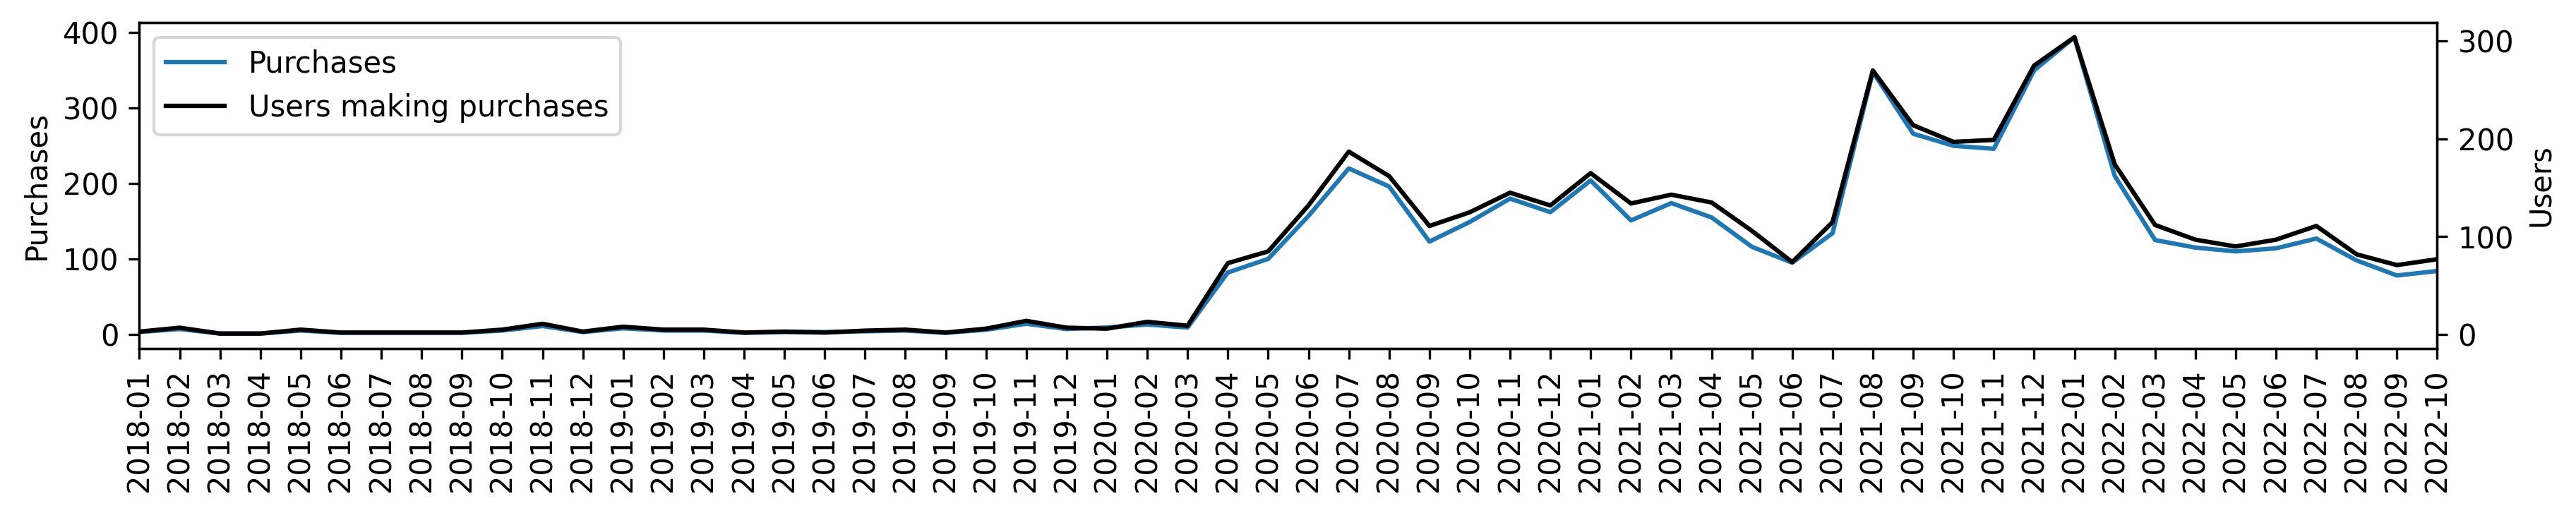

In [98]:
# group by month
fig, ax = plt.subplots(1,1, figsize=(14,2), dpi=300)
facemask_purchases_m = face_mask_purchases_df.groupby(YYYY_MM)[RESPONSE_ID].agg(
    ['count','nunique']
).rename(columns={'count':'purchases', 'nunique': 'purchasers'})
display(facemask_purchases_m.head())
ax = plot_monthly_data(facemask_purchases_m['purchases'], label='Purchases', ax=ax, legend=False)
ax.set_ylabel('Purchases')
ax2 = ax.twinx()
plot_monthly_data(facemask_purchases_m['purchasers'], ax=ax2, 
                       label='Users making purchases', color='black', legend=False)
_ = ax.legend(handles=[ax.get_lines()[0], ax2.get_lines()[0]])
_ = ax2.set_ylabel('Users')

Note: The monthly number of distinct users making face mask purchases is closely aligned with total purchases

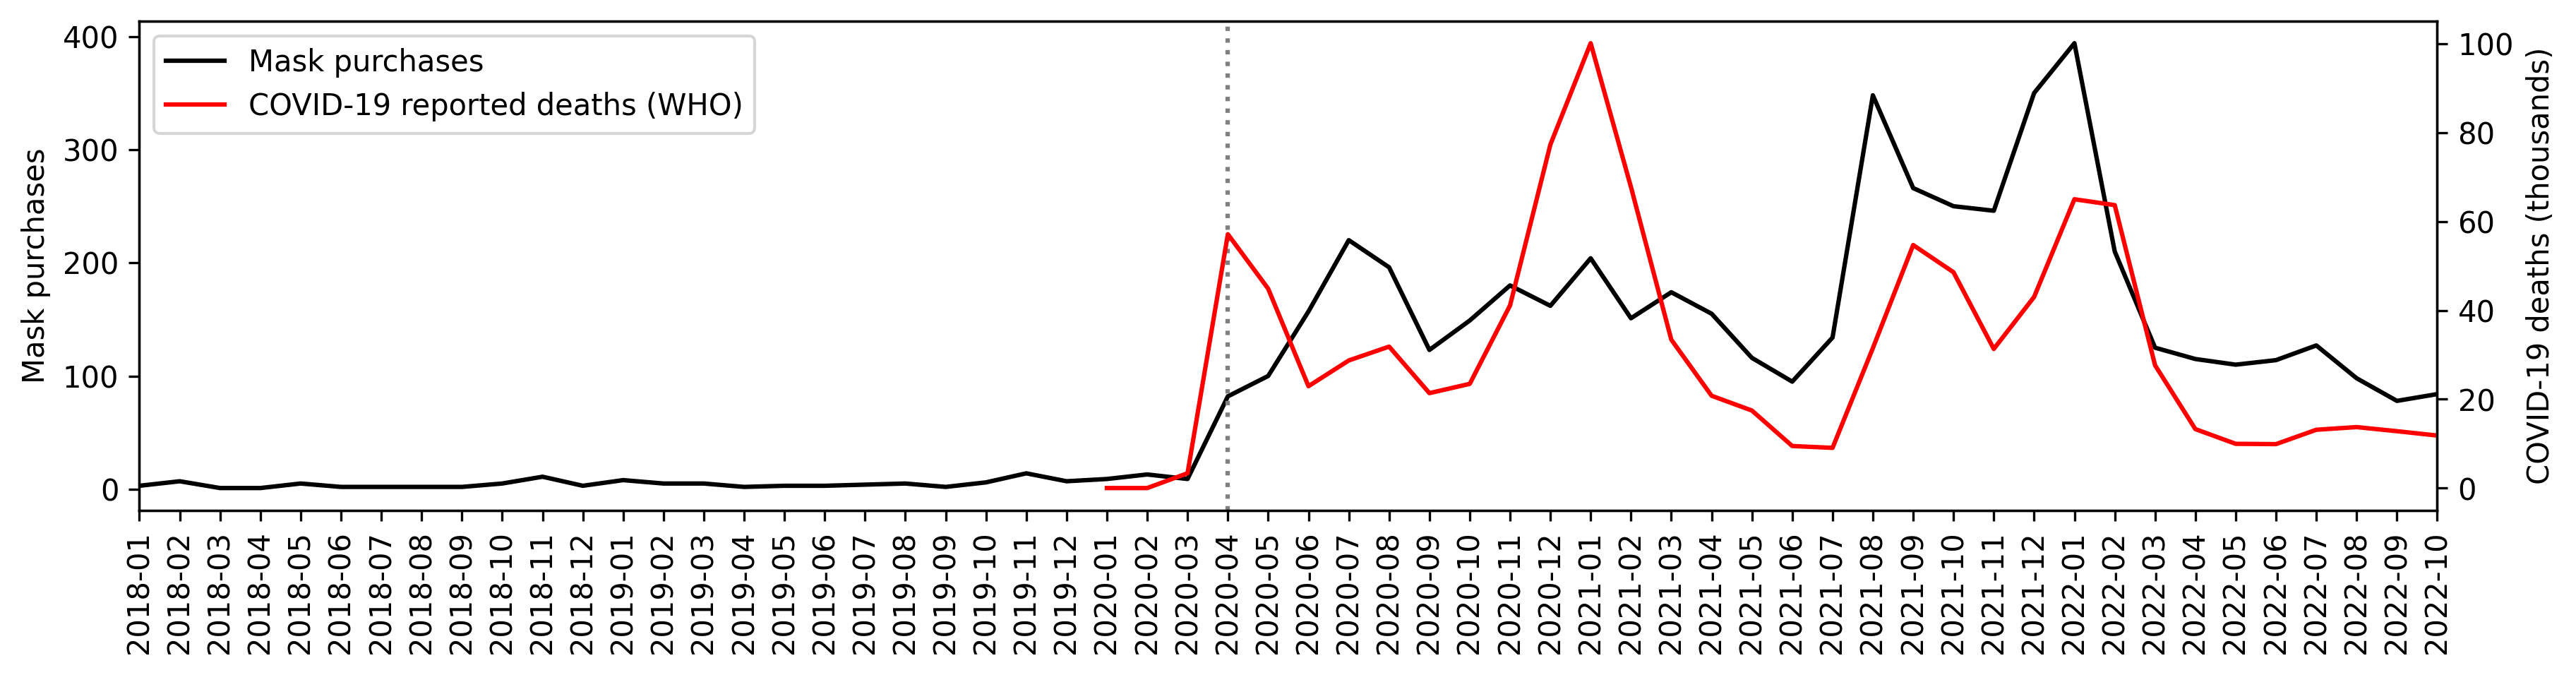

In [99]:
fig, ax = plt.subplots(1,1,figsize=(14,3), dpi=300)
ax = plot_monthly_data(facemask_purchases_m['purchases'], ax=ax, 
                       label='Mask purchases', color='black')
ax.set_ylabel('Mask purchases')
ax2 = ax.twinx()
_ = plot_monthly_data(covid_data_m['New_deaths'].reindex(yyyy_mm_idx)/1000, ax=ax2, 
                     color='red', label='COVID-19 reported deaths (WHO)', legend=False)
ax2.set_ylabel('COVID-19 deaths (thousands)')
_ = ax.legend(handles=[ax.get_lines()[0], ax2.get_lines()[0]])
peak_dates = ['2020-04']#, '2021-01','2021-09','2022-01']
for d in peak_dates:
    ax.axvline(x=d, ymin=0, color='gray', linestyle=':')

### CPI (Footwear)

This is not meant to be validation. This is meant to illustrate how corporate data could potentially be used to help public agencies estimate statistics.

#### CPI data


Data from FRED

Using: Consumer Price Index for All Urban Consumers: X in U.S. City Average (CPI-U)
- Not seasonally adjusted
- Monthly data, index
- Dates: 2018-01-01 to 2022-12-01
- set base index=100 set to date 2018-01-01

- Footwear: CUUR0000SEAE
- Also includes overall

In spreadsheet: [link](https://docs.google.com/spreadsheets/d/1DgkMyQyKFEKsutZm63ux3bV6flkyPadvssrv-CU_pKo/edit#gid=1014509328)


In [100]:
cpi_fname = census_data_dir + 'CPI_base_2018_multiple_categories.csv'
cpi_data = pd.read_csv(cpi_fname, parse_dates=['DATE'], usecols=['DATE', 'ALL','FOOTWEAR'])
# transform DATE column to yyyy-mm to match purchases data
cpi_data['yyyy-mm'] = cpi_data['DATE'].apply(lambda d: d.strftime('%Y-%m'))
cpi_data = cpi_data.set_index('yyyy-mm').loc[:MAX_YYYY_MM].drop('DATE', axis=1)
cpi_footwear = cpi_data['FOOTWEAR']
cpi_data.head(3)

ALL   FOOTWEAR
yyyy-mm                      
2018-01  100.00000  100.00000
2018-02  100.45347  102.12468
2018-03  100.68061  105.24331

Note that category specific CPIs do not all line up. e.g. Footwear CPI does not match the overall CPI.

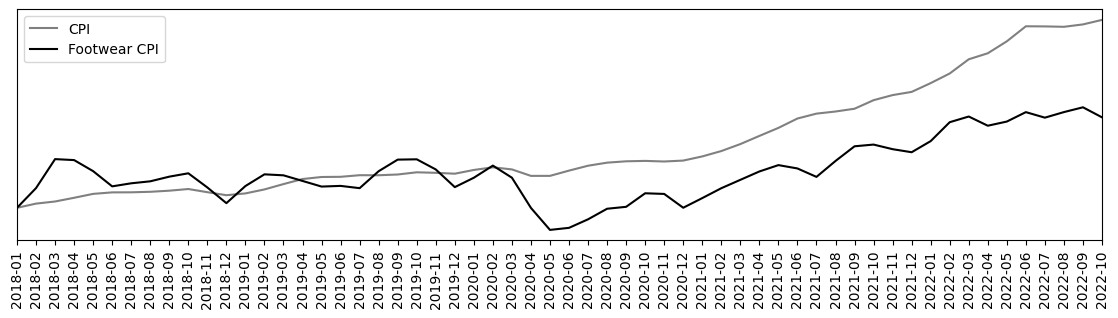

In [101]:
fig, ax = plt.subplots(1,1,figsize=(14,3))#, dpi=300)
plot_monthly_data(cpi_data['ALL'], ax=ax, label='CPI', color='gray')
_ = plot_monthly_data(cpi_data['FOOTWEAR'], ax=ax, label='Footwear CPI', color='black')
_ = ax.set_yticks([]) # remove the tick labels since they are not important

#### Footwear prices in purchases data

Collect the monthly median price for products in footwear categories

In [102]:
footwear_cats = ['SHOES', 'TECHNICAL_SPORT_SHOE', 'BOOT', 'SANDAL', 'SLIPPER']
footwear_purchases = amzn_df[amzn_df[CATEGORY].isin(footwear_cats)]
print('%s footwear purchases from %s distinct purchasers' % (len(footwear_purchases), footwear_purchases[RESPONSE_ID].nunique()))
footwear_purchases.groupby(CATEGORY)[RESPONSE_ID].agg(['count','nunique']).sort_values('count', ascending=False)

20885 footwear purchases from 3344 distinct purchasers


count  nunique
Category                            
SHOES                 11969     2711
SANDAL                 3506     1400
BOOT                   2880     1338
SLIPPER                2411     1230
TECHNICAL_SPORT_SHOE    119       97

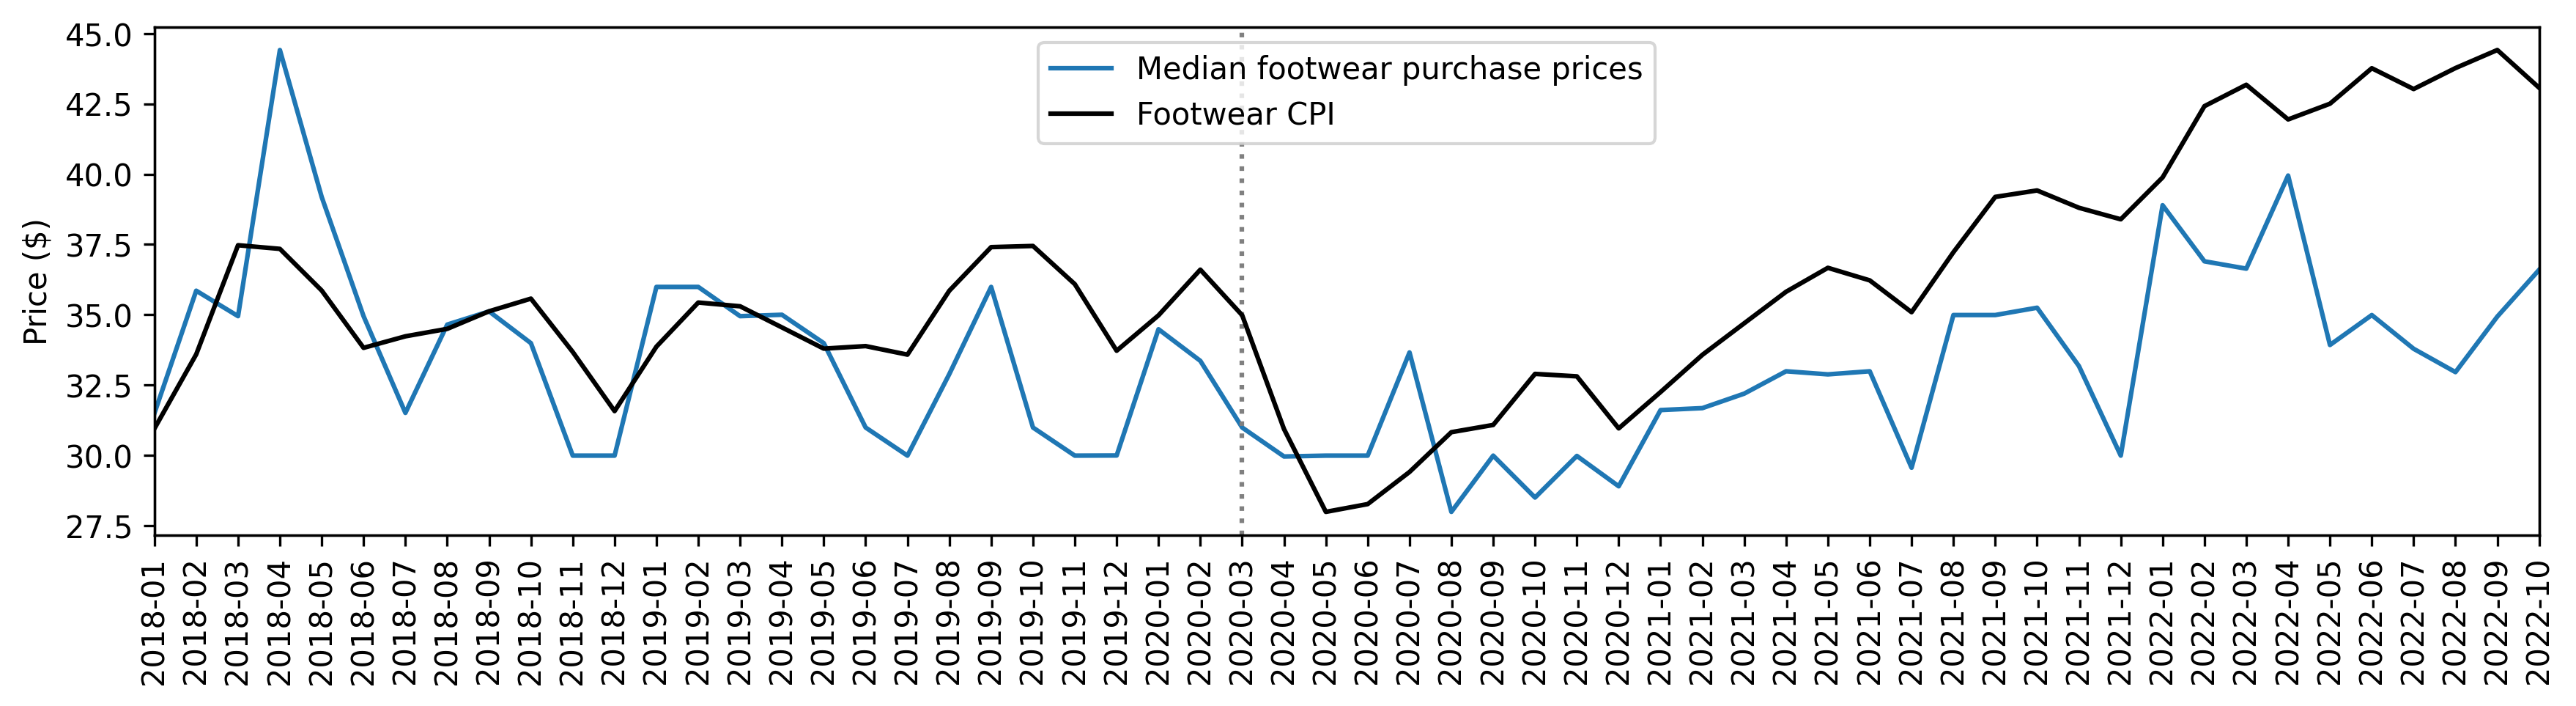

In [103]:
footwear_prices_med = footwear_purchases.groupby(YYYY_MM)[UNIT_PRICE].agg('median')
fig, ax = plt.subplots(1,1,figsize=(14,3), dpi=300)
ax = plot_monthly_data(footwear_prices_med, ax=ax, 
                       show_covid=True, label='Median footwear purchase prices', legend=False)
ax.set_ylabel('Price ($)')
ax2 = ax.twinx()
_ = plot_monthly_data(cpi_data['FOOTWEAR'], ax=ax2, 
                      label='Footwear CPI', color='black', legend=False)
#plot_monthly_data(cpi_data['ALL'], ax=ax2, label='CPI (overall)', color='lightgray', legend=False)
_ = ax.legend(handles=[ax.get_lines()[0]] + ax2.get_lines(), loc='upper center')
_ = ax2.set_yticks([]) # remove the tick labels since they are not important

In [104]:
# correlation analysis
(r, pvalue) = pearsonr(cpi_data['FOOTWEAR'], footwear_prices_med)
print('Pearson r=%0.3f, p=%.3f' % (r, pvalue))

Pearson r=0.536, p=0.000


Linear regression (OLS)

footwear_cpi ~ intercept + footwear_prices_med + post_covid + t

where:
- post_covid: boolean indicating if date is before or after COVID. 0 if yyyy-mm < 2020-03; 1 otherwise
- t: captures time based trend. define as 1,2,3,...

In [105]:
data = pd.DataFrame({
    'footwear_cpi': cpi_data['FOOTWEAR'],
    'cpi': cpi_data['ALL'],
    'footwear_prices_med': footwear_prices_med,
    'post_covid': [(0 if ym < '2020-03' else 1) for ym in yyyy_mm_idx],
    't': [i+1 for i in range(len(yyyy_mm_idx))],
})
data.head(3)

footwear_cpi        cpi  footwear_prices_med  post_covid  t
yyyy-mm                                                             
2018-01     100.00000  100.00000               31.490           0  1
2018-02     102.12468  100.45347               35.855           0  2
2018-03     105.24331  100.68061               34.950           0  3

In [106]:
# Linear regression
formula = 'footwear_cpi ~ footwear_prices_med + post_covid' # R2=0.392
formula = 'footwear_cpi ~ footwear_prices_med + post_covid + t' # R2=0.793
# formula = 'footwear_cpi ~ footwear_prices_med + post_covid + cpi' # R2=0.892
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Formula:
footwear_cpi ~ footwear_prices_med + post_covid + t


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           footwear_cpi   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     68.85
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           1.86e-18
Time:                        18:03:37   Log-Likelihood:                -104.47
No. Observations:                  58   AIC:                             216.9
Df Residuals:                      54   BIC:                             225.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              84.7541      2.220     38.183      0.000      80.304      89.204
footwear_prices_med     0.4444      0.067      6.678      0.000       0.311       0.578
post_covid             -5.2042      0.823     -6.320      0.000      -6.855      -3.553
t                       0.2469      0.024     10.222      0.000       0.198       0.295
==============================================================================
Omnibus:                        1.075   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.584   Jarque-Bera (JB):                0.497
Skew:                           0.181   Prob(JB):                        0.780
Kurtosis:                       3.274   Cond. No.                         514.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""